**<div style="text-align: right;">Uqaily, Raafay</div>**

<div style="text-align: right"> Student ID: 12225382 </div>

**FINM 33150 - Quantitative Trading Strategies**
<br>
Winter 2024

<h2><center> Homework 5: Foreign Exchange Carry Trade Strategy </center></h2>

## 1. Introduction

**Carry Trade**
<br>
<br>
A carry trade strategy, particularly common in the foreign exchange (forex) and fixed income markets, involves borrowing funds in a currency or financial instrument with a low interest rate and then using those funds to invest in another currency or instrument with a higher interest rate. The goal is to profit from the spread between these rates. This strategy is based on the assumption that exchange rates or price levels will remain stable or move in a direction favorable to the trade, allowing the investor to gain from the interest rate differential.
<br>
<br>
Specifically, in the context of the forex market, a carry trade involves borrowing in a currency with a low interest rate and investing in a currency yielding a higher interest rate. This is typically arranged via a cross-currency swap. The profit is derived from the difference in interest rates between the two currencies, assuming the exchange rates do not move unfavorably.
<br>
<br>
Profit = (Interest Rate Differential - Currency Depreciation) * Leverage
<br>
<br>
Where:
- **Interest Rate Differential**: The difference between the interest rates of the two currencies.
- **Currency Depreciation**: Any loss in value of the invested currency against the borrowed currency.
- **Leverage**: The use of borrowed money to increase the potential return of the investment.
<br>
<br>

**Risks**
<br>
<br>
1. **Exchange Rate Risk**: The most significant risk in a forex carry trade is the potential for the exchange rate to move unfavorably. If the currency you have invested in depreciates against the currency you borrowed, it can erase any interest gains and even lead to a net loss.
2. **Interest Rate Risk**: Changes in interest rates can also impact carry trades. If the interest rate of the currency you have borrowed in rises, or if the interest rate of the currency you have invested in falls, the profit margin of the carry trade can diminish.
3. **Liquidity Risk**: In some cases, it may become difficult to exit an investment without incurring significant losses if the market for either of the currencies involved becomes illiquid.
4. **Market Sentiment and Volatility**: Carry trades are sensitive to changes in market sentiment. In times of global financial uncertainty or increased volatility, currencies with higher yields may depreciate as investors flock to safer assets or currencies.
5. **Country-specific Risks**: Issues such as changes in regulatory policies, fiscal policies, or political instability in either country can pose risks to carry trades.

### Import Statements

In [3]:
import os
import quandl
import zipfile
import datetime
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style="ticks")
sns.color_palette("rocket", as_cmap=True)
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_market_calendars import get_calendar

### API Key

In [4]:
api_key = 'Enter API Key'

### Helper Functions

In [5]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(os.path.expanduser('~'), "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=api_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    zip_file_path = grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    try:
        with zipfile.ZipFile(zip_file_path) as zip_file:
            print("Contents of the zip file:")
            print(zip_file.namelist())
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")

    return pd.read_csv(zip_file_path)

In [6]:
def performance_summary(data, columns=None):
    """
    Returns the Performance Stats for specified columns of a given set of data.
    
    Inputs: 
        data - DataFrame with corresponding financial data.
        columns - List of column names to calculate statistics for.
    
    Output:
        summary_stats - DataFrame with summary statistics for specified columns.
    """

    if columns is None:
        columns = data.columns
        
    summary_stats = pd.DataFrame(index=columns)
    for column in columns:
        # Calculate statistics for each specified column
        summary_stats.loc[column, 'Mean'] = data[column].mean()
        summary_stats.loc[column, 'Median'] = data[column].median()
        summary_stats.loc[column, 'Volatility'] = data[column].std()
        summary_stats.loc[column, 'Sharpe Ratio'] = summary_stats.loc[column, 'Mean'] / summary_stats.loc[column, 'Volatility']
        summary_stats.loc[column, 'Skewness'] = data[column].skew()
        summary_stats.loc[column, 'Excess Kurtosis'] = data[column].kurtosis()
        summary_stats.loc[column, 'Min'] = data[column].min()
        summary_stats.loc[column, 'Max'] = data[column].max()
        
        # Calculate VaR and CVaR at 95% confidence level
        confidence_level = 0.95
        var_95 = data[column].quantile(1 - confidence_level)
        cvar_95 = data[column][data[column] <= var_95].mean()
        
        summary_stats.loc[column, 'VaR 95%'] = var_95
        summary_stats.loc[column, 'CVaR 95%'] = cvar_95

    return summary_stats

In [7]:
def exploratory_plot(df):
    """
    Plots two subplots:
    1. A forex rate against the Date column.
    2. Both 1Y and 5Y yield columns against the Date column, including the correlation between them.

    Input:
        df - DataFrame with financial data including a Date column, a forex rate column, 
             and 1Y and 5Y yield columns.
    """
    
    # Find the forex rate column
    forex_rate_col = [col for col in df.columns if col.endswith('forex_rate') and 'GBP' not in col][0]
    # Find the 1Y and 5Y yield columns
    yield_1Y_col = [col for col in df.columns if col.startswith('1Y_yield')][0]
    yield_5Y_col = [col for col in df.columns if col.startswith('5Y_yield')][0]
    
    # Calculate the correlation between 1Y and 5Y yields
    correlation = df[yield_1Y_col].corr(df[yield_5Y_col])
    
    # Start plotting
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot the forex rate
    axs[0].plot(df['Date'], df[forex_rate_col], label=forex_rate_col)
    axs[0].set_title(f'Change Over Time: {forex_rate_col}')
    axs[0].set_xlabel('Date')
    axs[0].set_ylabel(forex_rate_col)
    axs[0].legend()
    
    # Plot the 1Y and 5Y yields
    axs[1].plot(df['Date'], df[yield_1Y_col], label=yield_1Y_col)
    axs[1].plot(df['Date'], df[yield_5Y_col], label=yield_5Y_col)
    axs[1].set_title(f'Change Over Time: {yield_1Y_col} and {yield_5Y_col}')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Yield')
    axs[1].text(0.98, 0.95, f'Correlation: {correlation:.2f}', horizontalalignment='right', verticalalignment='top', transform=axs[1].transAxes)
    axs[1].legend(loc='upper left')
    
    # Improve layout and show plot
    plt.tight_layout()
    plt.show()

In [127]:
def compute_zcb_curve5(df):
    zcb_rates = pd.DataFrame(index=df.index)

    # Iterate over the columns of the input DataFrame (each column is a different tenor)
    for tenor_str in df.columns[4:]:  # Skip the earlier columns
        # Extract the numeric part of the tenor (e.g., "1Y_yield_EGP" -> 1.0)
        tenor = float(tenor_str.split('_')[0][:-1])
        curve = tenor_str.replace('yield', 'ZCB')  # Create a new column name for the ZCB rate (e.g., "1Y_yield_EGP" -> "1Y_ZCB_EGP")
        zcb_rates[curve] = np.nan  # Initialize the column with NaNs

        for i, row in df.iterrows():
            spot_rate = row[tenor_str]
            if tenor > 0.001:
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate
                # For the first row, there are no preceding ZCB rates to interpolate, so we initialize it to the spot rate
                if i == 0 or zcb_rates[curve].isna().all():  # Check if all values are NaN
                    z = np.full_like(times, spot_rate)
                else:
                    # Ensure we have at least two points to interpolate
                    if zcb_rates[curve].dropna().shape[0] > 1:
                        z = np.interp(times, zcb_rates[curve].dropna().index, zcb_rates[curve].dropna().values)
                    else:
                        z = np.full_like(times, spot_rate)  # Fallback if not enough points
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rate = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
                zcb_rates.at[i, curve] = zcb_rate

    # Return the DataFrame with the ZCB rates
    return zcb_rates

In [106]:
def compute_zcb_curve6(df):
    zcb_rates = pd.DataFrame(index=df.index)

    # Iterate over the columns of the input DataFrame (each column is a different tenor)
    for tenor_str in df.columns[:1]:  # Skip the earlier columns
        # Extract the numeric part of the tenor (e.g., "1Y_yield_EGP" -> 1.0)
        tenor = float(tenor_str.split('_')[0][:-1])
        curve = tenor_str.replace('spot', 'ZCB')  # Create a new column name for the ZCB rate (e.g., "1Y_yield_EGP" -> "1Y_ZCB_EGP")
        zcb_rates[curve] = np.nan  # Initialize the column with NaNs

        for i, row in df.iterrows():
            spot_rate = row[tenor_str]
            if tenor > 0.001:
                times = np.arange(tenor - 0.5, 0, step=-0.5)[::-1]
                coupon_half_yr = 0.5 * spot_rate
                # For the first row, there are no preceding ZCB rates to interpolate, so we initialize it to the spot rate
                if i == 0 or zcb_rates[curve].isna().all():  # Check if all values are NaN
                    z = np.full_like(times, spot_rate)
                else:
                    # Ensure we have at least two points to interpolate
                    if zcb_rates[curve].dropna().shape[0] > 1:
                        z = np.interp(times, zcb_rates[curve].dropna().index, zcb_rates[curve].dropna().values)
                    else:
                        z = np.full_like(times, spot_rate)  # Fallback if not enough points
                preceding_coupons_val = (coupon_half_yr * np.exp(-z * times)).sum()
                zcb_rate = -np.log((1 - preceding_coupons_val) / (1 + coupon_half_yr)) / tenor
                zcb_rates.at[i, curve] = zcb_rate

    # Return the DataFrame with the ZCB rates
    return zcb_rates

In [281]:
def plot_cumulative_performance(df1, df2, df3, df4):
    """
    Plot PnL from multiple dataframes.
    
    Args:
    - dataframes: List of DataFrames, each containing 'EnterDate', 'CumulativePnL', and 'CumulativeReturn' columns.
    """
    fig, axs = plt.subplots(4, figsize=(12, 8))

    
    axs[0].plot(df1.index, df1['PnL'], color='blue')
    axs[1].plot(df2.index, df2['PnL'], color='green')
    axs[2].plot(df3.index, df3['PnL'], color='orange')
    axs[3].plot(df4.index, df4['PnL'], color='purple')

    axs[0].set_title('PnL Over Time for EGP')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Change in PnL')

    axs[1].set_title('PnL Over Time for HUF')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change in PnL')
    
    axs[2].set_title('PnL Over Time for CRC')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Change in PnL')
    
    axs[3].set_title('PnL Over Time for RON')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Change in PnL')

    plt.tight_layout()
    plt.show()

In [287]:
def plot_PnLChange_performance(df1, df2, df3, df4):
    """
    Plot PnL from multiple dataframes.
    
    Args:
    - dataframes: List of DataFrames, each containing 'EnterDate', 'CumulativePnL', and 'CumulativeReturn' columns.
    """
    fig, axs = plt.subplots(4, figsize=(12, 8))

    
    axs[0].plot(df1.index, df1['PnLChange-EGP'], color='blue')
    axs[1].plot(df2.index, df2['PnLChange-HUF'], color='green')
    axs[2].plot(df3.index, df3['PnLChange-CRC'], color='orange')
    axs[3].plot(df4.index, df4['PnLChange-RON'], color='purple')

    axs[0].set_title('PnL Change Over Time for EGP')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Change in PnL (%)')

    axs[1].set_title('PnL Change Over Time for HUF')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change in PnL (%)')
    
    axs[2].set_title('PnL Change Over Time for CRC')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Change in PnL (%)')
    
    axs[3].set_title('PnL Change Over Time for RON')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Change in PnL (%)')

    plt.tight_layout()
    plt.show()

In [299]:
def plot_ReturnChange_performance(df1, df2, df3, df4):
    """
    Plot PnL from multiple dataframes.
    
    Args:
    - dataframes: List of DataFrames, each containing 'EnterDate', 'CumulativePnL', and 'CumulativeReturn' columns.
    """
    fig, axs = plt.subplots(4, figsize=(12, 8))

    
    axs[0].plot(df1.index, df1['ReturnChange-EGP'], color='blue')
    axs[1].plot(df2.index, df2['ReturnChange-HUF'], color='green')
    axs[2].plot(df3.index, df3['ReturnChange-CRC'], color='orange')
    axs[3].plot(df4.index, df4['ReturnChange-RON'], color='purple')

    axs[0].set_title('Return Change Over Time for EGP')
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Change in Return (%)')

    axs[1].set_title('Return Change Over Time for HUF')
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Change in Return (%)')
    
    axs[2].set_title('Return Change Over Time for CRC')
    axs[2].set_xlabel('Time')
    axs[2].set_ylabel('Change in Return (%)')
    
    axs[3].set_title('Return Change Over Time for RON')
    axs[3].set_xlabel('Time')
    axs[3].set_ylabel('Change in Return (%)')

    plt.tight_layout()
    plt.show()

## 2. Data Extraction

### UK Overnight Index Swaps (OIS) Data

<span style="color: rgb(0, 0, 128);"> The code below extracts daily UK OIS rate data from an excel file. The data in the excel sheet was compiled from the "Daily overnight index swap curve: archive data" zip file found on the Bank of England's website, which combined data from 2 separate files (one file had data from 2009 to 2015 while the second file had data from 2016 to 2024). Specifically, from each file, data was taken from the first column (this column had rates for 1-month maturity columns - based on the assignment instructions for retriving "shortest available rates") from the spot curve sheets. Then at the end, any dates for which data was not available were removed from the dataframe. </span>

In [10]:
uk_ois_data = pd.read_excel("UK_OIS_Daily_data.xlsx")
uk_ois_data['UK OIS spot curve rate'] = pd.to_numeric(uk_ois_data['UK OIS spot curve rate'], errors='coerce')
uk_ois_data = uk_ois_data.dropna(subset=['UK OIS spot curve rate'])
uk_ois_data

,date,UK OIS spot curve rate
1,2009-01-02,1.279724
2,2009-01-05,1.204601
3,2009-01-06,1.173760
4,2009-01-07,1.113437
5,2009-01-08,1.090821
...,...,...
3930,2024-01-25,5.186049
3931,2024-01-26,5.187021
3932,2024-01-29,5.186146
3933,2024-01-30,5.186303


### Spot FX Rate USD vs GBP

<span style="color: rgb(0, 0, 128);"> Although the fetch_quandl_table helper function was primarily used, due to "A required privilege is not held by the client error" in retriving data from within a zip file into a pandas dataframe on my new laptop, the code below extracted the daily spot fx rate for the Great Britain Pound (GBP) from a csv file. The data was reorganized in ascending order by date, and the code column was dropped. </span>

In [11]:
# spot_fx_usd_gbp = fetch_quandl_table('EDI/CUR', code='GBP', avoid_download=False)
spot_fx_usd_gbp = pd.read_csv("EDI_CUR_44116b509a17ec99027e9e0e31c24485.csv")
spot_fx_usd_gbp['date'] = pd.to_datetime(spot_fx_usd_gbp['date'])
spot_fx_usd_gbp = spot_fx_usd_gbp.sort_values(by='date', ascending=True)
spot_fx_usd_gbp = spot_fx_usd_gbp.drop(columns=['code'])
spot_fx_usd_gbp

,date,rate
8735,2000-01-01,0.618877
8734,2000-01-02,0.618877
8733,2000-01-03,0.614647
8732,2000-01-04,0.610927
8731,2000-01-05,0.609433
...,...,...
4,2024-02-10,0.791828
3,2024-02-11,0.791828
2,2024-02-12,0.791845
1,2024-02-13,0.792588


### Spot FX Rate USD vs EGP

<span style="color: rgb(0, 0, 128);"> Although the fetch_quandl_table helper function was primarily used, due to "A required privilege is not held by the client error" in retriving data from within a zip file into a pandas dataframe on my new laptop, the code below extracted the daily spot fx rate for the Egyptian Pound (EGP) from a csv file. The data was reorganized in ascending order by date, and the code column was dropped. </span>

In [12]:
# spot_fx_usd_egp = fetch_quandl_table('EDI/CUR', code='EGP', avoid_download=False)
spot_fx_usd_egp = pd.read_csv("EDI_CUR_EGP.csv")
spot_fx_usd_egp['date'] = pd.to_datetime(spot_fx_usd_egp['date'])
spot_fx_usd_egp = spot_fx_usd_egp.sort_values(by='date', ascending=True)
spot_fx_usd_egp = spot_fx_usd_egp.drop(columns=['code'])
spot_fx_usd_egp

,date,rate
8628,2000-05-31,3.445940
8627,2000-06-01,3.442826
8626,2000-06-02,3.438227
8625,2000-06-03,3.438227
8624,2000-06-04,3.438227
...,...,...
409,2024-02-10,30.900000
408,2024-02-11,30.900000
0,2024-02-12,30.869900
407,2024-02-13,30.900300


### Spot FX Rate USD vs HUF

<span style="color: rgb(0, 0, 128);"> Although the fetch_quandl_table helper function was primarily used, due to "A required privilege is not held by the client error" in retriving data from within a zip file into a pandas dataframe on my new laptop, the code below extracted the daily spot fx rate for the Hungarian Forint (HUF) from a csv file. The data was reorganized in ascending order by date, and the code column was dropped. </span>

In [13]:
# spot_fx_usd_huf = fetch_quandl_table('EDI/CUR', code='HUF', avoid_download=False)

spot_fx_usd_huf = pd.read_csv("EDI_CUR_HUF.csv")
spot_fx_usd_huf['date'] = pd.to_datetime(spot_fx_usd_huf['date'])
spot_fx_usd_huf = spot_fx_usd_huf.sort_values(by='date', ascending=True)
spot_fx_usd_huf = spot_fx_usd_huf.drop(columns=['code'])
spot_fx_usd_huf

,date,rate
8782,2000-01-01,251.766863
8781,2000-01-02,251.766863
8780,2000-01-03,251.694743
8779,2000-01-04,247.740170
8778,2000-01-05,246.607345
...,...,...
4,2024-02-10,358.820000
3,2024-02-11,358.820000
2,2024-02-12,358.656350
1,2024-02-13,359.636018


### Spot FX Rate USD vs CRC

<span style="color: rgb(0, 0, 128);"> Although the fetch_quandl_table helper function was primarily used, due to "A required privilege is not held by the client error" in retriving data from within a zip file into a pandas dataframe on my new laptop, the code below extracted the daily spot fx rate for the Costa Rican Colon (CRC) from a csv file. The data was reorganized in ascending order by date, and the code column was dropped. </span>

In [14]:
# spot_fx_usd_crc = fetch_quandl_table('EDI/CUR', code='CRC', avoid_download=False)

spot_fx_usd_crc = pd.read_csv("EDI_CUR_CRC.csv")
spot_fx_usd_crc['date'] = pd.to_datetime(spot_fx_usd_crc['date'])
spot_fx_usd_crc = spot_fx_usd_crc.sort_values(by='date', ascending=True)
spot_fx_usd_crc = spot_fx_usd_crc.drop(columns=['code'])
spot_fx_usd_crc

,date,rate
8650,2000-05-31,306.793507
8649,2000-06-01,306.623794
8648,2000-06-02,305.804383
8647,2000-06-03,305.804383
8646,2000-06-04,305.804383
...,...,...
409,2024-02-10,516.254665
408,2024-02-11,516.254665
0,2024-02-12,515.682841
407,2024-02-13,516.864131


### Spot FX Rate USD vs RON

<span style="color: rgb(0, 0, 128);"> Although the fetch_quandl_table helper function was primarily used, due to "A required privilege is not held by the client error" in retriving data from within a zip file into a pandas dataframe on my new laptop, the code below extracted the daily spot fx rate for the Romanian Leu (RON) from a csv file. The data was reorganized in ascending order by date, and the code column was dropped. </span>

In [15]:
# spot_fx_usd_ron = fetch_quandl_table('EDI/CUR', code='RON', avoid_download=False)

spot_fx_usd_ron = pd.read_csv("EDI_CUR_RON.csv")
spot_fx_usd_ron['date'] = pd.to_datetime(spot_fx_usd_ron['date'])
spot_fx_usd_ron = spot_fx_usd_ron.sort_values(by='date', ascending=True)
spot_fx_usd_ron = spot_fx_usd_ron.drop(columns=['code'])
spot_fx_usd_ron

,date,rate
7775,2000-01-03,1.811607
7774,2000-01-04,1.831651
7773,2000-01-05,1.834029
7772,2000-01-06,1.820461
7771,2000-01-07,1.832895
...,...,...
4,2024-02-10,4.614100
3,2024-02-11,4.614100
2,2024-02-12,4.612600
1,2024-02-13,4.621400


### Swap Rate Data

<span style="color: rgb(0, 0, 128);"> The code below extracts inferred yield curve data for the various currencies from a file uploaded on the class website. </span>

In [16]:
swap_rate = pd.read_csv("InferredYieldCurves_2024.tab", sep='\t')
swap_rate

,Unnamed: 0,shortname,tenor,date,yield
0,3401,Arab Rep Egypt,10Y,2010-01-04,0.075885
1,3402,Arab Rep Egypt,10Y,2010-01-05,0.074642
2,3403,Arab Rep Egypt,10Y,2010-01-06,0.074318
3,3404,Arab Rep Egypt,10Y,2010-01-07,0.073642
4,3405,Arab Rep Egypt,10Y,2010-01-08,0.073024
...,...,...,...,...,...
324689,323564,Utd Mexican Sts,6M,2024-01-29,0.053356
324690,323565,Utd Mexican Sts,6M,2024-01-30,0.053339
324691,323566,Utd Mexican Sts,6M,2024-01-31,0.053286
324692,323567,Utd Mexican Sts,6M,2024-02-01,0.052837


### EGP Swap Rates

<span style="color: rgb(0, 0, 128);"> The code below filters the swap_rate dataframe from above to analyze swap rate data specifically for the "Arab Rep Egypt" by performing several operations. Initially, it selects rows where the 'shortname' column matches 'Arab Rep Egypt', creating a subset swap_rate_egp. It then removes unnecessary columns ('Unnamed: 0' and 'shortname'). The data is further split into two separate DataFrames based on the 'tenor' values of '1Y' and '5Y', focusing on one-year and five-year swap rates, respectively (since the assignment footer 4 mentions to use at least the 1 year and 5 year points). These DataFrames are renamed to distinguish the yield columns ('yield' to '1Y yield' and '5Y yield') for clarity. Next, it merges these two DataFrames on the 'date' column using an outer merge, ensuring all dates are included even if one tenor doesn't have data for that date, and sorts the merged DataFrame by date. It then interpolates missing values linearly to fill in any gaps in the data, ensuring continuity and completeness of the yield data over time (based on the assignment instructions that state: "you may need to interpolate from sparser data in some cases"). Finally, it selects the relevant columns ('date', '1Y yield', '5Y yield') for the final DataFrame swap_rates_egp, which neatly organizes the swap rates for both tenors over time for the EGP currency. </span>

In [17]:
swap_rate_egp = swap_rate[swap_rate['shortname'] == 'Arab Rep Egypt']

swap_rate_egp = swap_rate_egp.drop(columns=['Unnamed: 0', 'shortname'])
df_1y = swap_rate_egp[swap_rate_egp['tenor'] == '1Y']
df_5y = swap_rate_egp[swap_rate_egp['tenor'] == '5Y']
df_1y = df_1y.rename(columns={'yield': '1Y yield'})
df_5y = df_5y.rename(columns={'yield': '5Y yield'})

merged_df = pd.merge(df_1y, df_5y, on='date', how='outer')
merged_df = merged_df.sort_values('date')
merged_df.interpolate(method='linear', inplace=True)

final_columns = ['date', '1Y yield', '5Y yield']
swap_rates_egp = merged_df[final_columns]
swap_rates_egp

,date,1Y yield,5Y yield
0,2010-01-04,0.028901,0.061109
1,2010-01-05,0.027466,0.059096
2,2010-01-06,0.027161,0.058905
3,2010-01-07,0.026656,0.058715
4,2010-01-08,0.026583,0.057959
...,...,...,...
3670,2024-01-29,0.174729,0.215379
3671,2024-01-30,0.167042,0.206339
3672,2024-01-31,0.156395,0.196064
3673,2024-02-01,0.149683,0.191981


### HUF Swap Rates

<span style="color: rgb(0, 0, 128);"> The code below filters the swap_rate dataframe from above to analyze swap rate data specifically for the "Hungary" by performing several operations. Initially, it selects rows where the 'shortname' column matches 'Hungary', creating a subset swap_rate_huf. It then removes unnecessary columns ('Unnamed: 0' and 'shortname'). The data is further split into two separate DataFrames based on the 'tenor' values of '1Y' and '5Y', focusing on one-year and five-year swap rates, respectively. These DataFrames are renamed to distinguish the yield columns ('yield' to '1Y yield' and '5Y yield') for clarity. Next, it merges these two DataFrames on the 'date' column using an outer merge, ensuring all dates are included even if one tenor doesn't have data for that date, and sorts the merged DataFrame by date. It then interpolates missing values linearly to fill in any gaps in the data, ensuring continuity and completeness of the yield data over time (based on the assignment instructions that state: "you may need to interpolate from sparser data in some cases"). Finally, it selects the relevant columns ('date', '1Y yield', '5Y yield') for the final DataFrame swap_rates_huf, which neatly organizes the swap rates for both tenors over time for the HUF currency. </span>

In [18]:
swap_rate_huf = swap_rate[swap_rate['shortname'] == 'Hungary']

swap_rate_huf = swap_rate_huf.drop(columns=['Unnamed: 0', 'shortname'])
df_1y = swap_rate_huf[swap_rate_huf['tenor'] == '1Y']
df_5y = swap_rate_huf[swap_rate_huf['tenor'] == '5Y']
df_1y = df_1y.rename(columns={'yield': '1Y yield'})
df_5y = df_5y.rename(columns={'yield': '5Y yield'})

merged_df = pd.merge(df_1y, df_5y, on='date', how='outer')
merged_df = merged_df.sort_values('date')
merged_df.interpolate(method='linear', inplace=True)

final_columns = ['date', '1Y yield', '5Y yield']
swap_rates_huf = merged_df[final_columns]
swap_rates_huf

,date,1Y yield,5Y yield
0,2012-01-02,NaN,NaN
1,2012-01-03,0.073373,0.094674
2,2012-01-04,0.086901,0.104110
3,2012-01-05,0.088718,0.106980
4,2012-01-06,0.084647,0.100772
...,...,...,...
3150,2024-01-29,0.054115,0.057718
3151,2024-01-30,0.054499,0.057986
3152,2024-01-31,0.053805,0.057087
3153,2024-02-01,0.053128,0.055644


### CRC Swap Rates

<span style="color: rgb(0, 0, 128);"> The code below filters the swap_rate dataframe from above to analyze swap rate data specifically for the "Rep Costa Rica" by performing several operations. Initially, it selects rows where the 'shortname' column matches 'Rep Costa Rica', creating a subset swap_rate_crc. It then removes unnecessary columns ('Unnamed: 0' and 'shortname'). The data is further split into two separate DataFrames based on the 'tenor' values of '1Y' and '5Y', focusing on one-year and five-year swap rates, respectively. These DataFrames are renamed to distinguish the yield columns ('yield' to '1Y yield' and '5Y yield') for clarity. Next, it merges these two DataFrames on the 'date' column using an outer merge, ensuring all dates are included even if one tenor doesn't have data for that date, and sorts the merged DataFrame by date. It then interpolates missing values linearly to fill in any gaps in the data, ensuring continuity and completeness of the yield data over time (based on the assignment instructions that state: "you may need to interpolate from sparser data in some cases"). Finally, it selects the relevant columns ('date', '1Y yield', '5Y yield') for the final DataFrame swap_rates_crc, which neatly organizes the swap rates for both tenors over time for the CRC currency. </span>

In [19]:
swap_rate_crc = swap_rate[swap_rate['shortname'] == 'Rep Costa Rica']

swap_rate_crc = swap_rate_crc.drop(columns=['Unnamed: 0', 'shortname'])
df_1y = swap_rate_crc[swap_rate_crc['tenor'] == '1Y']
df_5y = swap_rate_crc[swap_rate_crc['tenor'] == '5Y']
df_1y = df_1y.rename(columns={'yield': '1Y yield'})
df_5y = df_5y.rename(columns={'yield': '5Y yield'})

merged_df = pd.merge(df_1y, df_5y, on='date', how='outer')
merged_df = merged_df.sort_values('date')
merged_df.interpolate(method='linear', inplace=True)

final_columns = ['date', '1Y yield', '5Y yield']
swap_rates_crc = merged_df[final_columns]
swap_rates_crc

,date,1Y yield,5Y yield
0,2010-01-04,0.012753,0.045461
1,2010-01-05,0.012151,0.044628
2,2010-01-06,0.011969,0.044834
3,2010-01-07,0.011799,0.044247
4,2010-01-08,0.015362,0.043650
...,...,...,...
3632,2024-01-29,0.103751,0.096680
3633,2024-01-30,0.104135,0.096955
3634,2024-01-31,0.103429,0.096064
3635,2024-02-01,0.102911,0.094929


### RON Swap Rates

<span style="color: rgb(0, 0, 128);"> The code below filters the swap_rate dataframe from above to analyze swap rate data specifically for the "Romania" by performing several operations. Initially, it selects rows where the 'shortname' column matches 'Romania', creating a subset swap_rate_ron. It then removes unnecessary columns ('Unnamed: 0' and 'shortname'). The data is further split into two separate DataFrames based on the 'tenor' values of '1Y' and '5Y', focusing on one-year and five-year swap rates, respectively. These DataFrames are renamed to distinguish the yield columns ('yield' to '1Y yield' and '5Y yield') for clarity. Next, it merges these two DataFrames on the 'date' column using an outer merge, ensuring all dates are included even if one tenor doesn't have data for that date, and sorts the merged DataFrame by date. It then interpolates missing values linearly to fill in any gaps in the data, ensuring continuity and completeness of the yield data over time (based on the assignment instructions that state: "you may need to interpolate from sparser data in some cases"). Finally, it selects the relevant columns ('date', '1Y yield', '5Y yield') for the final DataFrame swap_rates_ron, which neatly organizes the swap rates for both tenors over time for the RON currency. </span>

In [20]:
swap_rate_ron = swap_rate[swap_rate['shortname'] == 'Romania']

swap_rate_ron = swap_rate_ron.drop(columns=['Unnamed: 0', 'shortname'])
df_1y = swap_rate_ron[swap_rate_ron['tenor'] == '1Y']
df_5y = swap_rate_ron[swap_rate_ron['tenor'] == '5Y']
df_1y = df_1y.rename(columns={'yield': '1Y yield'})
df_5y = df_5y.rename(columns={'yield': '5Y yield'})

merged_df = pd.merge(df_1y, df_5y, on='date', how='outer')
merged_df = merged_df.sort_values('date')
merged_df.interpolate(method='linear', inplace=True)

final_columns = ['date', '1Y yield', '5Y yield']
swap_rates_ron = merged_df[final_columns]
swap_rates_ron

,date,1Y yield,5Y yield
0,2010-01-04,0.037587,0.064773
1,2010-01-05,0.032862,0.059161
2,2010-01-06,0.029377,0.059474
3,2010-01-07,0.026526,0.058454
4,2010-01-08,0.026391,0.057286
...,...,...,...
3656,2024-01-29,0.054566,0.060311
3657,2024-01-30,0.055047,0.060601
3658,2024-01-31,0.054417,0.059677
3659,2024-02-01,0.053999,0.058601


### Trading Days Calculation

<span style="color: rgb(0, 0, 128);"> The code below utilizes the pandas_market_calendars python package to determine the number of trading days between 1st January, 2009 to 31st January, 2024 since the UK OIS data is only available between those dates. Now, I will ensure all my other data is also available between those dates. As done above, I will continue to interpolate missing values such that I have 3795 data points for all: UK OIS rate, forex rates, and yield curve rates data. </span>

In [21]:
#Use the NYSE Calendar for reference

start_date = '01-01-2009'
end_date = '01-31-2024'

nyse = get_calendar('XNYS')
trading_days = nyse.valid_days(start_date=start_date, end_date=end_date)
num_trading_days = len(trading_days)

df_trading_days = pd.DataFrame(trading_days, columns=['Date'])
df_trading_days['Date'] = pd.to_datetime(df_trading_days['Date'])
df_trading_days['Date'] = df_trading_days['Date'].dt.date

print("The number of trading days over the entire time period is:", num_trading_days, "days.")

The number of trading days over the entire time period is: 3795 days.


### GBP Data (OIS Spot Rate + Forex Rate)

<span style="color: rgb(0, 0, 128);"> This code consolidates data from three different DataFrames—df_trading_days, uk_ois_data, and spot_fx_usd_gbp—into a single DataFrame. Initially, it ensures all date columns across the three DataFrames are in a consistent datetime format. It then merges df_trading_days with uk_ois_data on their date columns, keeping all dates from df_trading_days and corresponding data from uk_ois_data, while dropping the redundant 'date' column from uk_ois_data. The process repeats by merging this intermediate DataFrame with spot_fx_usd_gbp using the same methodology, ensuring all trading days are included and aligning the spot FX USD/GBP rates with the previously merged data. After cleaning up and renaming relevant columns, it applies linear interpolation to fill in any missing values across the entire dataset, providing a continuous set of data points for analysis. </span> 

In [115]:
df_trading_days['Date'] = pd.to_datetime(df_trading_days['Date'])
uk_ois_data['date'] = pd.to_datetime(uk_ois_data['date'])
spot_fx_usd_gbp['date'] = pd.to_datetime(spot_fx_usd_gbp['date'])

merged_df = pd.merge(df_trading_days, uk_ois_data, left_on='Date', right_on='date', how='left')
merged_df = merged_df.drop(columns=['date'])
merged_df = merged_df.rename(columns={'UK OIS spot curve rate': 'UK_OIS_spot_rate'})

final_merged_df = pd.merge(merged_df, spot_fx_usd_gbp, left_on='Date', right_on='date', how='left')
final_merged_df = final_merged_df.drop(columns=['date'])
final_merged_df = final_merged_df.rename(columns={'rate': 'USD_GBP_forex_rate'})

gbp_data = final_merged_df.interpolate(method='linear', axis=0)
gbp_data = gbp_data.rename(columns={'UK_OIS_spot_rate': '0.8Y_UK_OIS_spot_rate'})
gbp_data = gbp_data.set_index('Date')

gbp_zcb = compute_zcb_curve6(gbp_data)
gbp_data = pd.merge(gbp_data, gbp_zcb, left_on='Date', right_on='Date', how='left')

gbp_data

,0.8Y_UK_OIS_spot_rate,USD_GBP_forex_rate,0.8Y_UK_OIS_ZCB_rate
Date,,,
2009-01-02,1.279724,0.691197,1.333845
2009-01-05,1.204601,0.684299,1.269415
2009-01-06,1.173760,0.677736,1.201939
2009-01-07,1.113437,0.661384,1.136980
2009-01-08,1.090821,0.656772,1.112845
...,...,...,...
2024-01-25,5.186049,0.786664,NaN
2024-01-26,5.187021,0.787178,NaN
2024-01-29,5.186146,0.787272,NaN


### EGP Data (Forex Rate + Swap Rate + GBP Data)

<span style="color: rgb(0, 0, 128);"> Just like above, this code integrates and organizes data from three DataFrames—gbp_data, spot_fx_usd_egp, and swap_rates_egp. After doing so, I filtered this consolidated DataFrame to include only data within the specified date range from January 1, 2012, to January 31, 2024 (this was done because the HUF currency was missing 1Y and 5Y yield curve rates from Jan 2009 to Dec 2012 and since interpolation was already done individually, I decided it was best to just remove the years 2009 to 2012 from the analysis instead of doing further interpolation), resulting in a focused dataset (egp_data) that combines GBP data, USD/EGP forex rates, and EGP swap rates for 1-year and 5-year tenors from 2012 to 2024. I also added the zcb curve results using the helper function defined above. </span> 

In [149]:
gbp_data.index = pd.to_datetime(gbp_data.index)
spot_fx_usd_egp['date'] = pd.to_datetime(spot_fx_usd_egp['date'])
swap_rates_egp['date'] = pd.to_datetime(swap_rates_egp['date'])

merged_df = pd.merge(gbp_data, spot_fx_usd_egp, left_on='Date', right_on='date', how='left')
#merged_df = merged_df.drop(columns=['Date'])
merged_df = merged_df.rename(columns={'rate': 'USD_EGP_forex_rate'})

final_merged_df = pd.merge(merged_df, swap_rates_egp, left_on='date', right_on='date', how='left')
#final_merged_df = final_merged_df.drop(columns=['date'])
final_merged_df = final_merged_df.rename(columns={'1Y yield': '1Y_yield_EGP', '5Y yield': '5Y_yield_EGP'})

start_date = '01-01-2012'
end_date = '01-31-2024'

egp_data = final_merged_df[(final_merged_df.date >= start_date) & (final_merged_df.date <= end_date)]
egp_data = egp_data.set_index('date')

egp_data['0.8Y_UK_OIS_spot_rate'] = egp_data['0.8Y_UK_OIS_spot_rate']/100

egp_zcb = compute_zcb_curve5(egp_data)
egp_data = pd.merge(egp_data, egp_zcb, left_on='date', right_on='date', how='left')

egp_data

,0.8Y_UK_OIS_spot_rate,USD_GBP_forex_rate,0.8Y_UK_OIS_ZCB_rate,USD_EGP_forex_rate,1Y_yield_EGP,5Y_yield_EGP,1Y_ZCB_EGP,5Y_ZCB_EGP
date,,,,,,,,
2012-01-03,0.005115,0.640025,0.519680,6.031583,0.069056,0.093031,0.067870,0.090436
2012-01-04,0.005194,0.640657,0.527660,6.032009,0.069053,0.092895,0.067868,0.090308
2012-01-05,0.005175,0.645233,0.525704,6.034389,0.068256,0.093576,0.067104,0.091696
2012-01-06,0.005143,0.647701,0.522497,6.034202,0.068235,0.093454,0.067083,0.091552
2012-01-09,0.005129,0.647302,0.521122,6.033425,0.069334,0.093852,0.068164,0.092025
...,...,...,...,...,...,...,...,...
2024-01-25,0.051860,0.786664,NaN,30.898900,0.172834,0.211081,0.170115,0.307862
2024-01-26,0.051870,0.787178,NaN,30.905393,0.173173,0.212339,0.170450,0.311848
2024-01-29,0.051861,0.787272,NaN,30.999770,0.174729,0.215379,0.171986,0.321798


<span style="color: rgb(0, 0, 128);"> After consulting with Satyajit during his TA session, I was advised to simply keep data from every Wednesday to make it easier while implementing the trading strategy. Hence, I filter the dataframe to only include dates that fall on wednesday. </span> 

In [150]:
egp_data_wed = egp_data[egp_data.index.dayofweek == 2]

### HUF Data (Forex Rate + Swap Rate + GBP Data)

<span style="color: rgb(0, 0, 128);"> Just like above, this code integrates and organizes data from three DataFrames—gbp_data, spot_fx_usd_huf, and swap_rates_huf. After doing so, I filtered this consolidated DataFrame to include only data within the specified date range from January 1, 2012, to January 31, 2024 (this was done because the HUF currency was missing 1Y and 5Y yield curve rates from Jan 2009 to Dec 2012 and since interpolation was already done individually, I decided it was best to just remove the years 2009 to 2012 from the analysis instead of doing further interpolation), resulting in a focused dataset (huf_data) that combines GBP data, USD/HUF forex rates, and HUF swap rates for 1-year and 5-year tenors from 2012 to 2024. I also added the zcb curve results using the helper function defined above. </span> 

In [131]:
gbp_data.index = pd.to_datetime(gbp_data.index)
spot_fx_usd_huf['date'] = pd.to_datetime(spot_fx_usd_huf['date'])
swap_rates_huf['date'] = pd.to_datetime(swap_rates_huf['date'])

merged_df = pd.merge(gbp_data, spot_fx_usd_huf, left_on='Date', right_on='date', how='left')
#merged_df = merged_df.drop(columns=['date'])
merged_df = merged_df.rename(columns={'rate': 'USD_HUF_forex_rate'})

final_merged_df = pd.merge(merged_df, swap_rates_huf, left_on='date', right_on='date', how='left')
#final_merged_df = final_merged_df.drop(columns=['date'])
final_merged_df1 = final_merged_df.rename(columns={'1Y yield': '1Y_yield_HUF', '5Y yield': '5Y_yield_HUF'})

start_date = '01-01-2012'
end_date = '01-31-2024'

huf_data = final_merged_df1[(final_merged_df1.date >= start_date) & (final_merged_df1.date <= end_date)]
huf_data = huf_data.set_index('date')

huf_zcb = compute_zcb_curve5(huf_data)
huf_data = pd.merge(huf_data, huf_zcb, left_on='date', right_on='date', how='left')

huf_data

,0.8Y_UK_OIS_spot_rate,USD_GBP_forex_rate,0.8Y_UK_OIS_ZCB_rate,USD_HUF_forex_rate,1Y_yield_HUF,5Y_yield_HUF,1Y_ZCB_HUF,5Y_ZCB_HUF
date,,,,,,,,
2012-01-03,0.511479,0.640025,0.519680,242.379737,0.073373,0.094674,0.072035,0.091978
2012-01-04,0.519434,0.640657,0.527660,247.300105,0.086901,0.104110,0.085026,0.100787
2012-01-05,0.517484,0.645233,0.525704,249.820811,0.088718,0.106980,0.087135,0.107720
2012-01-06,0.514287,0.647701,0.522497,248.797313,0.084647,0.100772,0.083136,0.099987
2012-01-09,0.512916,0.647302,0.521122,247.663492,0.084575,0.099911,0.083064,0.098933
...,...,...,...,...,...,...,...,...
2024-01-25,5.186049,0.786664,NaN,356.225054,0.054166,0.058116,0.053195,0.052688
2024-01-26,5.187021,0.787178,NaN,355.222871,0.054365,0.058417,0.053390,0.052991
2024-01-29,5.186146,0.787272,NaN,358.072000,0.054115,0.057718,0.053145,0.052287


<span style="color: rgb(0, 0, 128);"> After consulting with Satyajit during his TA session, I was advised to simply keep data from every Wednesday to make it easier while implementing the trading strategy. Hence, I filter the dataframe to only include dates that fall on wednesday. </span> 

In [143]:
huf_data_wed = huf_data[huf_data.index.dayofweek == 2]

### CRC Data (Forex Rate + Swap Rate + GBP Data)

<span style="color: rgb(0, 0, 128);"> Just like above, this code integrates and organizes data from three DataFrames—gbp_data, spot_fx_usd_crc, and swap_rates_crc. After doing so, I filtered this consolidated DataFrame to include only data within the specified date range from January 1, 2012, to January 31, 2024 (this was done because the HUF currency was missing 1Y and 5Y yield curve rates from Jan 2009 to Dec 2012 and since interpolation was already done individually, I decided it was best to just remove the years 2009 to 2012 from the analysis instead of doing further interpolation), resulting in a focused dataset (crc_data) that combines GBP data, USD/CRC forex rates, and CRC swap rates for 1-year and 5-year tenors from 2012 to 2024. I also added the zcb curve results using the helper function defined above.</span> 

In [132]:
gbp_data.index = pd.to_datetime(gbp_data.index)
spot_fx_usd_crc['date'] = pd.to_datetime(spot_fx_usd_crc['date'])
swap_rates_crc['date'] = pd.to_datetime(swap_rates_crc['date'])

merged_df = pd.merge(gbp_data, spot_fx_usd_crc, left_on='Date', right_on='date', how='left')
#merged_df = merged_df.drop(columns=['date'])
merged_df = merged_df.rename(columns={'rate': 'USD_CRC_forex_rate'})

final_merged_df = pd.merge(merged_df, swap_rates_crc, left_on='date', right_on='date', how='left')
#final_merged_df = final_merged_df.drop(columns=['date'])
final_merged_df2 = final_merged_df.rename(columns={'1Y yield': '1Y_yield_CRC', '5Y yield': '5Y_yield_CRC'})

start_date = '01-01-2012'
end_date = '01-31-2024'

crc_data = final_merged_df2[(final_merged_df2.date >= start_date) & (final_merged_df2.date <= end_date)]
crc_data = crc_data.set_index('date')

crc_data = crc_data.interpolate(method='linear', axis=0)

crc_zcb = compute_zcb_curve5(crc_data)
crc_data = pd.merge(crc_data, crc_zcb, left_on='date', right_on='date', how='left')

crc_data

,0.8Y_UK_OIS_spot_rate,USD_GBP_forex_rate,0.8Y_UK_OIS_ZCB_rate,USD_CRC_forex_rate,1Y_yield_CRC,5Y_yield_CRC,1Y_ZCB_CRC,5Y_ZCB_CRC
date,,,,,,,,
2012-01-03,0.511479,0.640025,0.519680,505.227703,0.022814,0.043067,0.022684,0.042563
2012-01-04,0.519434,0.640657,0.527660,508.673245,0.021526,0.043903,0.021410,0.043378
2012-01-05,0.517484,0.645233,0.525704,511.648166,0.021426,0.043805,0.021305,0.043412
2012-01-06,0.514287,0.647701,0.522497,512.638425,0.021526,0.043606,0.021405,0.043198
2012-01-09,0.512916,0.647302,0.521122,511.116720,0.021426,0.043505,0.021305,0.043088
...,...,...,...,...,...,...,...,...
2024-01-25,5.186049,0.786664,8.454315,514.423545,0.103724,0.097075,0.103201,0.109435
2024-01-26,5.187021,0.787178,8.454315,515.010063,0.103920,0.097346,0.103396,0.109824
2024-01-29,5.186146,0.787272,8.454315,512.448895,0.103751,0.096680,0.103228,0.108870


<span style="color: rgb(0, 0, 128);"> After consulting with Satyajit during his TA session, I was advised to simply keep data from every Wednesday to make it easier while implementing the trading strategy. Hence, I filter the dataframe to only include dates that fall on wednesday. </span> 

In [144]:
crc_data_wed = crc_data[crc_data.index.dayofweek == 2]

### RON Data (Forex Rate + Swap Rate + GBP Data)

<span style="color: rgb(0, 0, 128);"> Just like above, this code integrates and organizes data from three DataFrames—gbp_data, spot_fx_usd_ron, and swap_rates_ron. After doing so, I filtered this consolidated DataFrame to include only data within the specified date range from January 1, 2012, to January 31, 2024 (this was done because the HUF currency was missing 1Y and 5Y yield curve rates from Jan 2009 to Dec 2012 and since interpolation was already done individually, I decided it was best to just remove the years 2009 to 2012 from the analysis instead of doing further interpolation), resulting in a focused dataset (egp_data) that combines GBP data, USD/RON forex rates, and RON swap rates for 1-year and 5-year tenors from 2012 to 2024. I also added the zcb curve results using the helper function defined above. </span> 

In [133]:
gbp_data.index = pd.to_datetime(gbp_data.index)
spot_fx_usd_ron['date'] = pd.to_datetime(spot_fx_usd_ron['date'])
swap_rates_ron['date'] = pd.to_datetime(swap_rates_ron['date'])

merged_df = pd.merge(gbp_data, spot_fx_usd_ron, left_on='Date', right_on='date', how='left')
#merged_df = merged_df.drop(columns=['date'])
merged_df = merged_df.rename(columns={'rate': 'USD_RON_forex_rate'})

final_merged_df = pd.merge(merged_df, swap_rates_ron, left_on='date', right_on='date', how='left')
#final_merged_df = final_merged_df.drop(columns=['date'])
final_merged_df3 = final_merged_df.rename(columns={'1Y yield': '1Y_yield_RON', '5Y yield': '5Y_yield_RON'})

start_date = '01-01-2012'
end_date = '01-31-2024'

ron_data = final_merged_df3[(final_merged_df3.date >= start_date) & (final_merged_df3.date <= end_date)]
ron_data = ron_data.set_index('date')

ron_zcb = compute_zcb_curve5(ron_data)
ron_data = pd.merge(ron_data, ron_zcb, left_on='date', right_on='date', how='left')

ron_data

,0.8Y_UK_OIS_spot_rate,USD_GBP_forex_rate,0.8Y_UK_OIS_ZCB_rate,USD_RON_forex_rate,1Y_yield_RON,5Y_yield_RON,1Y_ZCB_RON,5Y_ZCB_RON
date,,,,,,,,
2012-01-03,0.511479,0.640025,0.519680,3.316337,0.046664,0.068349,0.046122,0.067015
2012-01-04,0.519434,0.640657,0.527660,3.339661,0.049258,0.070389,0.048653,0.068968
2012-01-05,0.517484,0.645233,0.525704,3.385418,0.049028,0.071135,0.048465,0.070411
2012-01-06,0.514287,0.647701,0.522497,3.406619,0.048865,0.069908,0.048304,0.069009
2012-01-09,0.512916,0.647302,0.521122,3.421184,0.048911,0.070092,0.048349,0.069218
...,...,...,...,...,...,...,...,...
2024-01-25,5.186049,0.786664,NaN,4.574800,0.054623,0.060675,0.053996,0.058714
2024-01-26,5.187021,0.787178,NaN,4.590000,0.054835,0.060999,0.054206,0.059068
2024-01-29,5.186146,0.787272,NaN,4.592100,0.054566,0.060311,0.053940,0.058317


<span style="color: rgb(0, 0, 128);"> After consulting with Satyajit during his TA session, I was advised to simply keep data from every Wednesday to make it easier while implementing the trading strategy. Hence, I filter the dataframe to only include dates that fall on wednesday. </span> 

In [147]:
ron_data_wed = ron_data[ron_data.index.dayofweek == 2]

## 3. Preliminary Data Analysis

### GBP Data

<span style="color: rgb(0, 0, 128);"> The code below plots the changes in the UK Overnight Indexed Swap (OIS) spot rate and the USD/GBP foreign exchange rate over time using a line graph, with dates on the x-axis and the rates on the y-axis. It utilizes matplotlib for visualization, labeling each data series for clarity and rotating date labels for better readability. </span>  

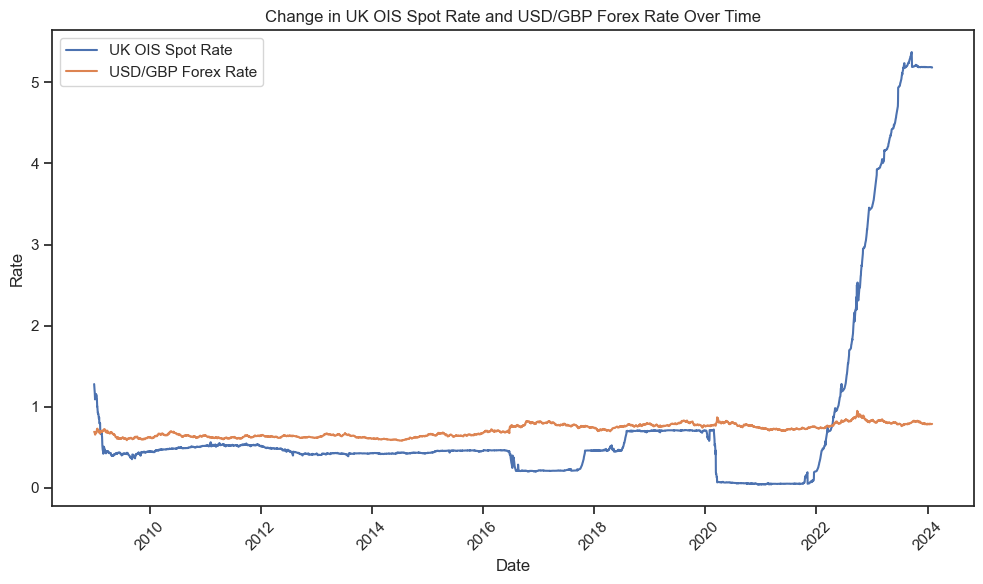

In [27]:
plt.figure(figsize=(10, 6))

plt.plot(gbp_data['Date'], gbp_data['UK_OIS_spot_rate'], label='UK OIS Spot Rate')
plt.plot(gbp_data['Date'], gbp_data['USD_GBP_forex_rate'], label='USD/GBP Forex Rate')

plt.title('Change in UK OIS Spot Rate and USD/GBP Forex Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<span style="color: rgb(255,69,0);"> Both rates appear relatively stable and closely correlated until around 2020, where a distinct divergence occurs. The UK OIS Spot Rate drops significantly around 2020, possibly indicating a central bank intervention or a market reaction to an economic event (most likely covid-19), before it recovers and remains stable again. Starting from around 2022, there is a sharp increase in the UK OIS Spot Rate, suggesting a dramatic change in the economic environment, such as tightening monetary policy or a significant shift in the demand for sterling liquidity. Meanwhile, the USD/GBP Forex Rate exhibits smaller fluctuations and a slight overall declining trend, indicating a gradual strengthening of the GBP against the USD over the same period. </span> 

In [28]:
columns_of_interest = ['UK_OIS_spot_rate', 'USD_GBP_forex_rate']
gbp_summary_statistics = performance_summary(gbp_data, columns=columns_of_interest)

gbp_summary_statistics

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
UK_OIS_spot_rate,0.798645,0.458197,1.177959,0.677990,2.883266,7.144153,0.039294,5.373719,0.051329,0.048744
USD_GBP_forex_rate,0.708320,0.708469,0.076655,9.240304,0.170402,-1.244133,0.582661,0.949311,0.605407,0.596735


<span style="color: rgb(255,69,0);"> Based on the summary statistics for UK_OIS_spot_rate, the mean rate is higher than the median, indicating a right-skewed distribution which suggests that there are outliers with high spot rates. The volatility is relatively high, showing that the spot rate experiences significant fluctuations. The Sharpe Ratio, which measures the risk-adjusted return, is less than one but still positive, indicating that the return per unit of risk is moderate. The positive skewness confirms the right-skewed nature of the data, and the high excess kurtosis indicates that the distribution has fat tails and is more peaked than a normal distribution. This could mean the presence of extreme values or higher than normal risk of large rate swings. The Value at Risk (VaR) and Conditional Value at Risk (CVaR) at the 95% confidence level are relatively low, suggesting that the potential loss in value is not very large on most days; however, the days with losses beyond the VaR might experience significant drops as suggested by the high kurtosis. </span>

<span style="color: rgb(255,69,0);"> For the USD_GBP_forex_rate, the mean and median are relatively close, indicating a distribution with less skew. The very low volatility suggests that the exchange rate is quite stable. The negative Sharpe Ratio is notable and suggests that, on average, holding this asset would have resulted in a performance worse than the risk-free rate of return over the period examined. The negative skewness indicates that there are more frequent small gains and a few large drops in the exchange rate. The negative excess kurtosis suggests that the distribution of returns is flatter than a normal distribution, with fewer extreme outliers than would be expected in a normal distribution. The VaR and CVaR are relatively higher than those for the OIS rate, suggesting a larger potential loss in value, which aligns with the negative skewness, indicating a risk of significant downward movements in the exchange rate. </span> 

### EGP Data

<span style="color: rgb(0, 0, 128);"> The code below uses the exploratory_plot function to plot the changes in the EGP forex rate and the 1Y and 5Y yield rate over time using a line graph, with dates on the x-axis and the rates on the y-axis. </span>

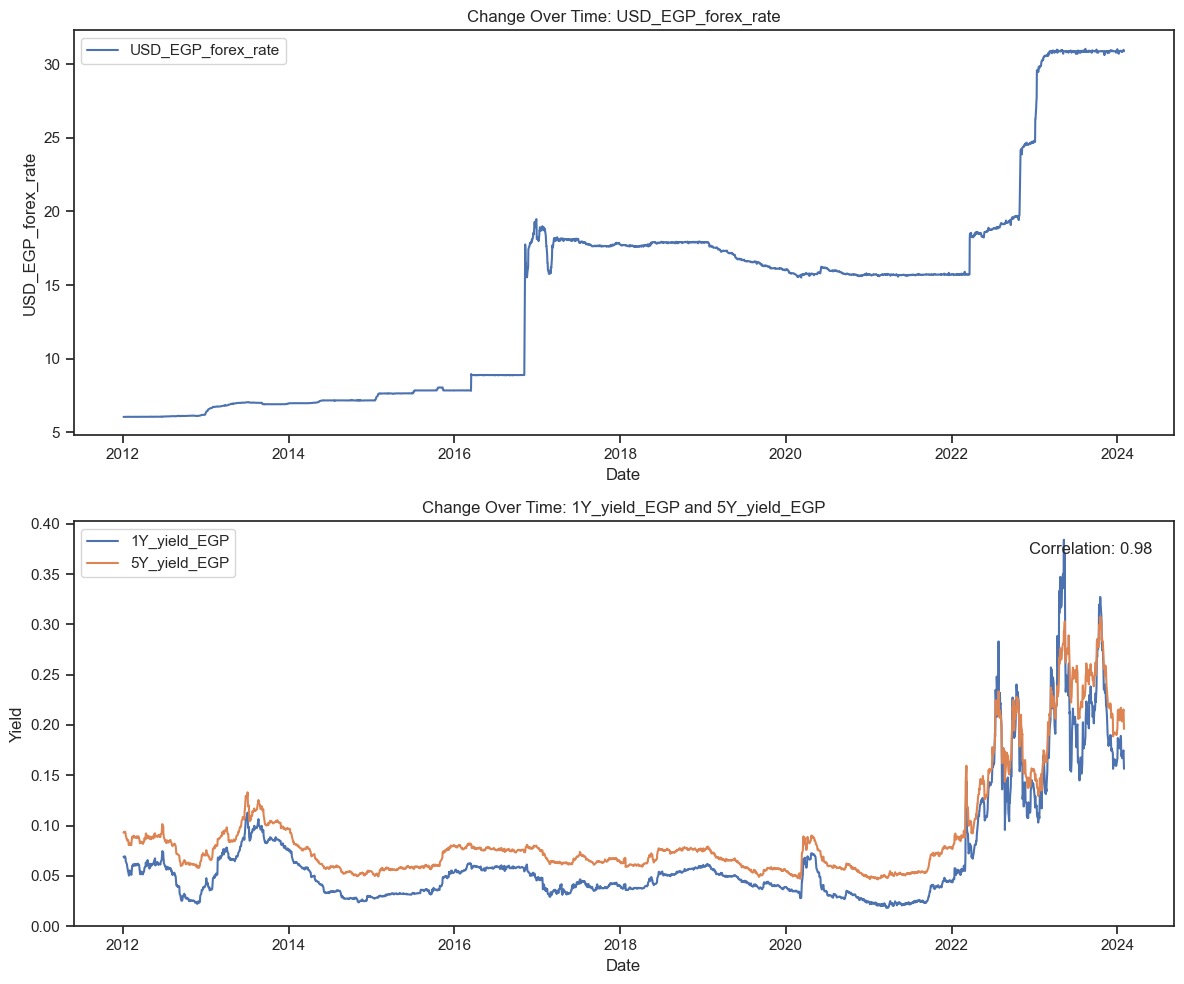

In [29]:
exploratory_plot(egp_data)

<span style="color: rgb(255,69,0);"> The first plot shows the USD/EGP (US Dollar to Egyptian Pound) forex rate over time, with a noticeable trend of stability until around 2016, where a significant depreciation of the EGP is observed, followed by periods of relative stability with minor fluctuations. The sharp increase in 2020 might indicate a devaluation or market reaction to a the COVID-19 pandemic and its aftermath, which affected global and local economies. The rate then remains elevated with slight volatility, which could be due to a range of factors including monetary policy adjustments, inflationary pressures, or continued economic uncertainties. </span> 

<span style="color: rgb(255,69,0);"> In the second plot, the correlation between the 1-year and 5-year Egyptian Pound yield curves is extremely high at 0.98, indicating that they move almost in tandem. The yields show a general trend of increase from around 2016, suggesting rising interest rates or inflation expectations during this period. The parallel movement could be reflective of consistent monetary policy direction or market sentiment towards Egyptian debt. The sharp upward spikes near the end, particularly pronounced in the 5-year yield, might suggest a recent event causing increased risk perceptions, possibly linked to global financial conditions, changes in Egypt's economic outlook, or geopolitical tensions that could be impacting investor confidence and demanding higher returns for the increased risk. </span> 

In [30]:
columns_of_interest = ['USD_EGP_forex_rate', '1Y_yield_EGP', '5Y_yield_EGP']
egp_summary_statistics = performance_summary(egp_data, columns=columns_of_interest)

egp_summary_statistics

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
USD_EGP_forex_rate,14.405299,15.715500,7.077897,2.035251,0.739066,0.069336,6.030446,31.065200,6.075209,6.043793
1Y_yield_EGP,0.067063,0.049358,0.056968,1.177197,2.386409,5.794201,0.018167,0.384100,0.023871,0.022043
5Y_yield_EGP,0.090045,0.073279,0.052880,1.702836,2.147277,3.814399,0.046448,0.307516,0.051085,0.049469


<span style="color: rgb(255,69,0);"> For the USD_EGP_forex_rate, the mean is significantly lower than the median, which suggests a left-skewed distribution, indicating that the majority of exchange rates are higher than the average rate. The high volatility indicates a large variation in exchange rate values over time, which is consistent with the visible sharp rises and periods of stability in the graph. A positive Sharpe Ratio that is greater than 2 suggests that the exchange rate provided a favorable return compared to the risk taken, although this might be more reflective of a devaluation trend rather than an investment return. The skewness is close to zero, which typically indicates a symmetric distribution, but this is contradicted by the mean-median relationship; this discrepancy could be due to the presence of extreme values affecting the mean. The excess kurtosis is very low, suggesting that the distribution of exchange rates does not have heavy tails and that extreme changes were less frequent than expected in a normal distribution. The VaR and CVaR indicate that there is a relatively small expected maximum loss at the 95% confidence level, but given the high volatility, these risk measures suggest that there may be occasional but significant outliers. </span> 

<span style="color: rgb(255,69,0);"> Regarding 1Y_yield_EGP and 5Y_yield_EGP, both yields show low mean values, with the 5-year yield being slightly less than the 1-year yield on average, which is unusual as longer-term yields typically exceed shorter-term yields, indicating a potential inversion in part of the yield curve. The volatility for both yields is low, suggesting stable interest rate movements over time. The Sharpe Ratios are positive but less than 1, indicating that any excess return over the risk-free rate is relatively small when adjusted for volatility. Both yields exhibit positive skewness, with the 1-year yield showing a much higher skewness, which suggests the presence of infrequent but large spikes in yield. The excess kurtosis is high for both, particularly for the 1-year yield, indicating a leptokurtic distribution with more frequent extreme deviations from the mean than a normal distribution would predict. The VaR and CVaR for both yields are quite close to zero, but the 1-year yield has a slightly higher potential for extreme loss, as indicated by its higher VaR and CVaR values. </span> 

### HUF Data

<span style="color: rgb(0, 0, 128);"> The code below uses the exploratory_plot function to plot the changes in the HUF forex rate and the 1Y and 5Y yield rate over time using a line graph, with dates on the x-axis and the rates on the y-axis. </span>

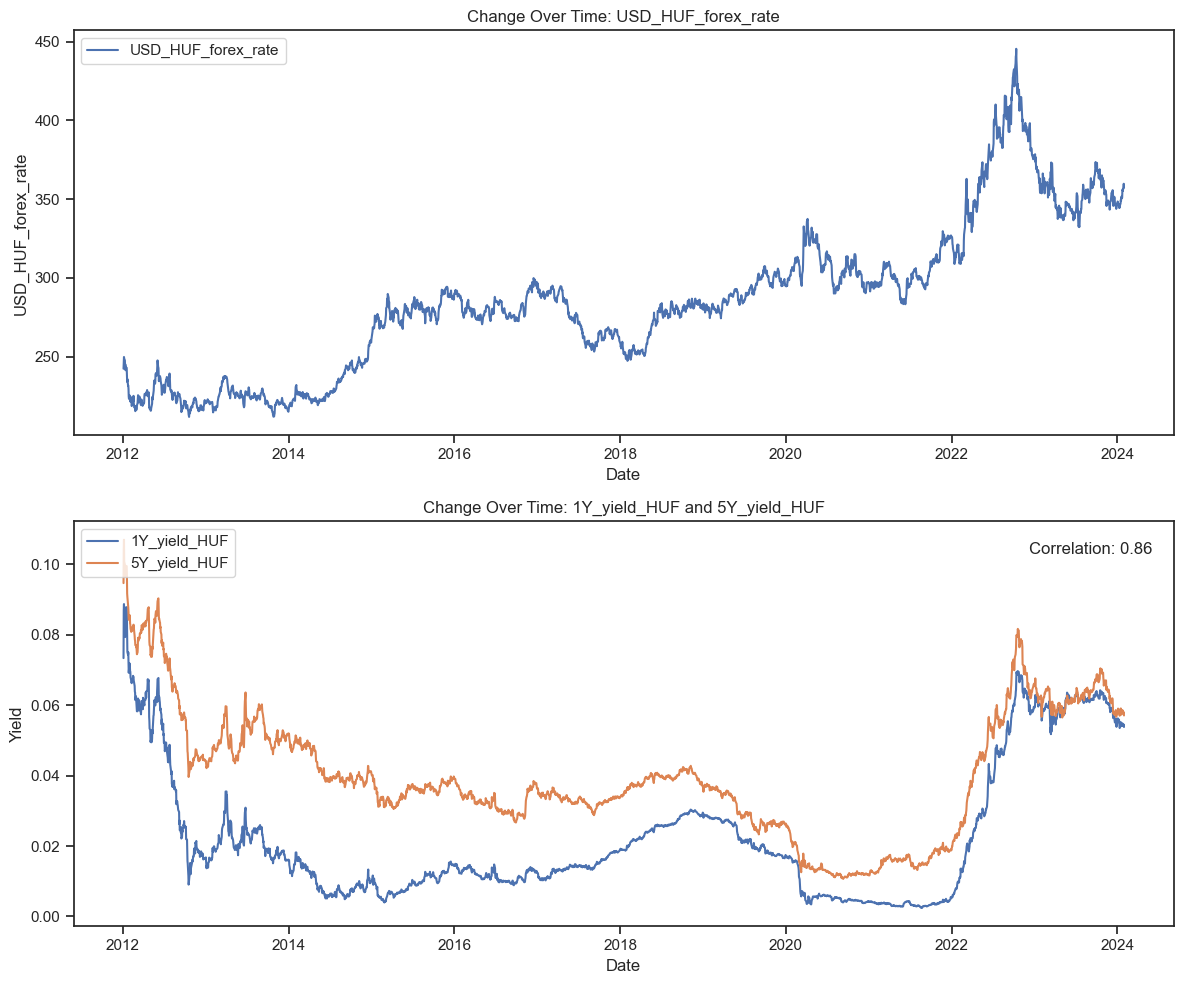

In [31]:
exploratory_plot(huf_data)

<span style="color: rgb(255,69,0);"> The first plot depicts the USD/HUF (US Dollar to Hungarian Forint) forex rate over time. The graph exhibits a long-term depreciation of the HUF against the USD from 2012 to around 2024, with some periods of relative stability and minor retracements. The trend shows a gradual increase in the forex rate up to around 2018, followed by more pronounced fluctuations leading to a sharp rise beginning in 2020. This could be reflective of macroeconomic factors such as differing inflation rates, Hungary's economic policies, or global USD strength. The peak around 2020-2021 might indicate market reactions to the economic impacts of the COVID-19 pandemic, monetary policy responses, or other significant global economic events affecting currency values. </span> 

<span style="color: rgb(255,69,0);"> The second plot presents the 1-year and 5-year yield curves for Hungarian government securities (denoted as HUF). Both yields show a declining trend from 2012 to around 2020, which could suggest a period of monetary easing or an economic environment with low inflation expectations. Around 2020, there is a notable increase in both yields, with the 5-year yield overtaking the 1-year yield, typically a sign of a normal upward sloping yield curve, which may indicate rising inflation expectations or a shift towards a tighter monetary policy stance. The yields seem to move closely together as is often the case, but it's noteworthy that the 5-year yield shows more pronounced movements, which could be indicative of greater sensitivity to longer-term economic expectations or risk assessments. </span> 

In [32]:
columns_of_interest = ['USD_HUF_forex_rate', '1Y_yield_HUF', '5Y_yield_HUF']
huf_summary_statistics = performance_summary(huf_data, columns=columns_of_interest)

huf_summary_statistics

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
USD_HUF_forex_rate,284.962367,282.527801,46.668363,6.106114,0.609477,0.171492,211.814787,445.435000,220.175509,217.517030
1Y_yield_HUF,0.022563,0.016173,0.018965,1.189720,1.223250,0.345143,0.002442,0.088718,0.003690,0.003180
5Y_yield_HUF,0.039835,0.037139,0.017670,2.254447,0.587028,0.152700,0.010649,0.106980,0.012799,0.011952


<span style="color: rgb(255,69,0);"> The USD_HUF_forex_rate shows a mean that is slightly above the median, suggesting a distribution that is not heavily skewed, as also indicated by the skewness value which is close to zero. The volatility is quite high, reflecting significant fluctuations in the exchange rate over the period analyzed, which is consistent with the overall upward trend and the sharp increases observed in the plot. The Sharpe Ratio is positive, indicating a modest excess return over the risk-free rate when adjusted for the volatility of the exchange rate. The low excess kurtosis suggests that the distribution of exchange rates does not have heavy tails, meaning extreme deviations from the mean are less frequent than would be expected in a normal distribution. The Value at Risk (VaR) and Conditional Value at Risk (CVaR) at the 95% confidence level are quite substantial, which, combined with the high volatility, suggests that there are periods with significant drops in value. </span> 

<span style="color: rgb(255,69,0);"> For the 1Y_yield_HUF, the mean is higher than the median, which is also supported by a skewness value greater than 1, indicating a distribution with a longer right tail where the yield values are occasionally significantly higher than the median. The volatility is relatively low, which, combined with the high Sharpe Ratio, suggests that the yield offers a good risk-adjusted return. The high excess kurtosis indicates that there are more outliers with extreme values than would be expected in a normal distribution, implying that investors may occasionally face unexpected large changes in the 1-year yield. The VaR and CVaR are very low, which suggests that the potential for extreme negative outcomes is minimal, but when they do occur, they can be significant, as indicated by the high kurtosis. </span> 

<span style="color: rgb(255,69,0);"> The 5Y_yield_HUF exhibits a mean that is greater than the median, and with a skewness less than 1 but still positive, it suggests a modestly right-skewed distribution. The volatility is extremely low, suggesting stable yield values over time, and the very high Sharpe Ratio indicates an excellent risk-adjusted performance. Similar to the 1-year yield, the 5-year yield also has a high excess kurtosis, which signals the presence of outliers with extreme values that are greater than what would be typically expected. The VaR and CVaR are both negligible, which indicates low expected losses at the 95% confidence level, but the high kurtosis suggests that the tails of the distribution are heavy, and the potential for extreme outcomes, while rare, could be impactful. </span>

### CRC Data

<span style="color: rgb(0, 0, 128);"> The code below uses the exploratory_plot function to plot the changes in the CRC forex rate and the 1Y and 5Y yield rate over time using a line graph, with dates on the x-axis and the rates on the y-axis. </span>

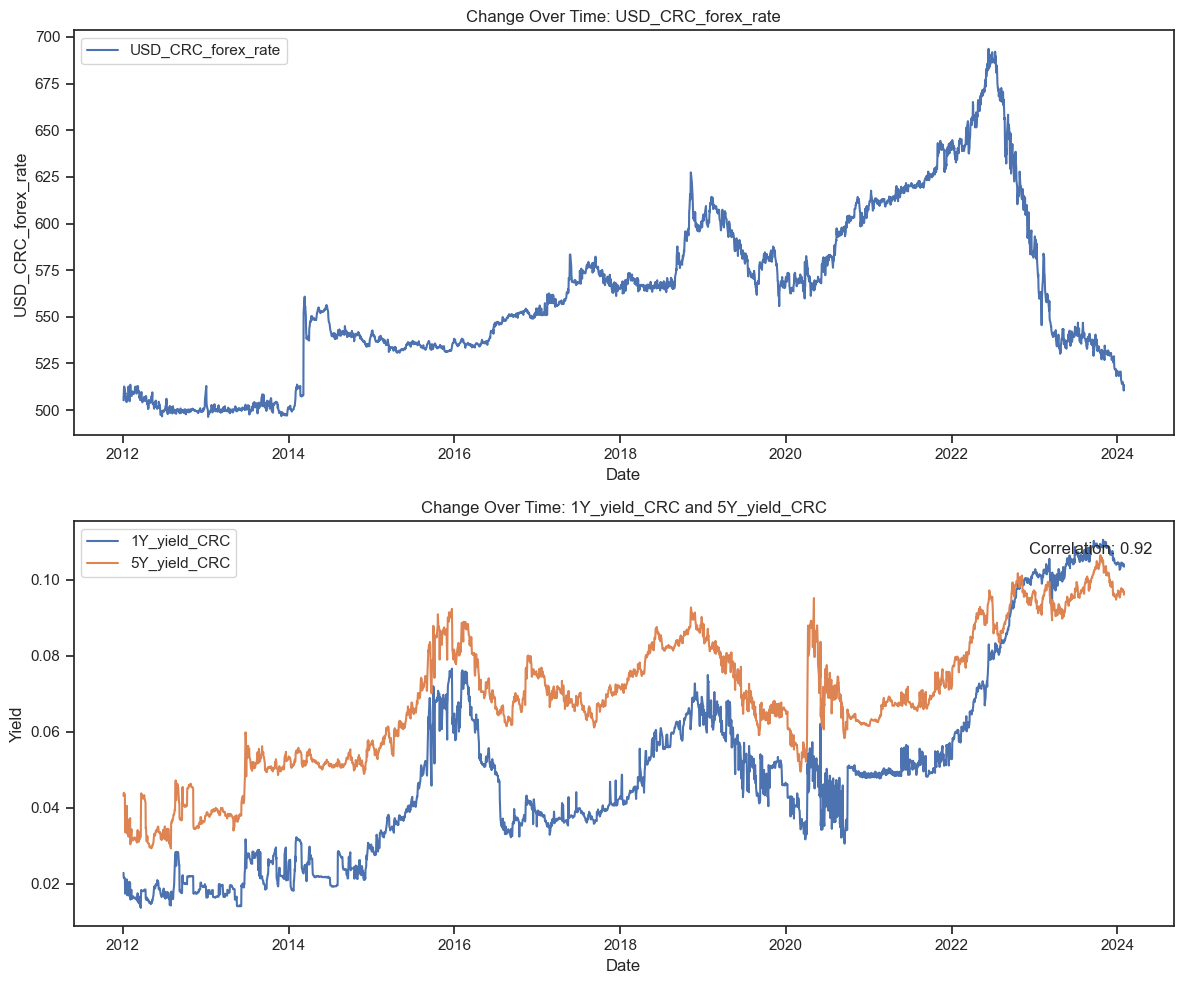

In [33]:
exploratory_plot(crc_data)

<span style="color: rgb(255,69,0);"> The first plot illustrates the USD/CRC (US Dollar to Costa Rican Colón) forex rate. Initially, from 2012 until around 2015, the rate was fairly stable with a slight downward trend, indicating a marginal appreciation of the CRC against the USD. However, this trend reversed into a gradual depreciation of the CRC from 2015, with the rate climbing steadily before a sharp increase around 2020, which could be indicative of economic stress or policy changes, potentially related to the global economic impact of the COVID-19 pandemic. This surge peaks sharply in 2022 and is followed by a dramatic decline, possibly reflecting stabilization efforts by the Costa Rican government or central bank, or a recovery phase post the height of the pandemic's economic challenges. </span> 

<span style="color: rgb(255,69,0);"> The second plot displays the 1-year and 5-year yield curves for Costa Rican government securities (CRC), with a high correlation of 0.92, suggesting that both yields are influenced by similar economic factors and move closely together. Initially, both yields experience significant volatility with a downward trend from 2012 to around 2015, which may correspond with a period of lower inflation or aggressive monetary easing. From around 2016, there is a rising trend that becomes more pronounced around 2020, likely due to inflationary pressures or a shift in monetary policy to combat economic issues. The yields peak in 2022, consistent with the forex rate plot, which could indicate a response to the same economic pressures or shocks. The subsequent convergence and decline in yields could reflect a market anticipation of easing inflation or improved economic conditions, possibly as the global economy begins to recover from the pandemic. </span> 

In [34]:
columns_of_interest = ['USD_CRC_forex_rate', '1Y_yield_CRC', '5Y_yield_CRC']
crc_summary_statistics = performance_summary(crc_data, columns=columns_of_interest)

crc_summary_statistics

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
USD_CRC_forex_rate,561.502982,556.140020,44.081982,12.737698,0.555536,-0.184286,496.340097,693.655915,499.731462,498.862434
1Y_yield_CRC,0.049377,0.046830,0.025168,1.961900,0.841276,0.038797,0.013600,0.110528,0.017403,0.016031
5Y_yield_CRC,0.068549,0.068473,0.017918,3.825731,-0.155004,-0.606403,0.029223,0.106479,0.036139,0.032898


<span style="color: rgb(255,69,0);"> The USD_CRC_forex_rate shows a mean that is very close to the median, suggesting a fairly symmetric distribution of exchange rate values, although the positive skewness indicates a slight tendency towards more frequent higher rates. The volatility is moderate, which reflects the fluctuations observed in the plot, including the significant spikes. The Sharpe Ratio is relatively high, indicating that holding US dollars against the CRC has provided a favorable risk-adjusted return over the period, which could be indicative of consistent depreciation of the CRC. The negative excess kurtosis suggests fewer extreme deviations from the mean than would be expected in a normal distribution, aligning with the relatively smooth trend seen in the plot before the spike. The Value at Risk (VaR) and Conditional Value at Risk (CVaR) are relatively high, indicating potential for significant downside risk, which may have materialized during the sharp increase around 2020-2022. </span> 

<span style="color: rgb(255,69,0);"> For the yield curves, the 1Y_yield_CRC and 5Y_yield_CRC both show low mean values, close to their respective medians, suggesting a balanced distribution of yields with minor skewness. The low volatility for both yields indicates stability in interest rates over time, with the 5-year yield being slightly less volatile than the 1-year yield. The Sharpe Ratios are very high, especially for the 5-year yield, suggesting that investors are well-compensated for the risks they take on, given the stability of the yields. The 5-year yield has a negative excess kurtosis, implying a distribution with lighter tails and less extreme outcomes than a normal distribution, which may indicate a market that is less prone to shocks. The 1-year yield, while also exhibiting low kurtosis, does not have as pronounced light-tailed behavior. Both VaR and CVaR are very low, reflecting minimal expected losses at the 95% confidence level, consistent with the overall low volatility and stable return profile of the yields. </span> 

### RON Data

<span style="color: rgb(0, 0, 128);"> The code below uses the exploratory_plot function to plot the changes in the CRC forex rate and the 1Y and 5Y yield rate over time using a line graph, with dates on the x-axis and the rates on the y-axis. </span>

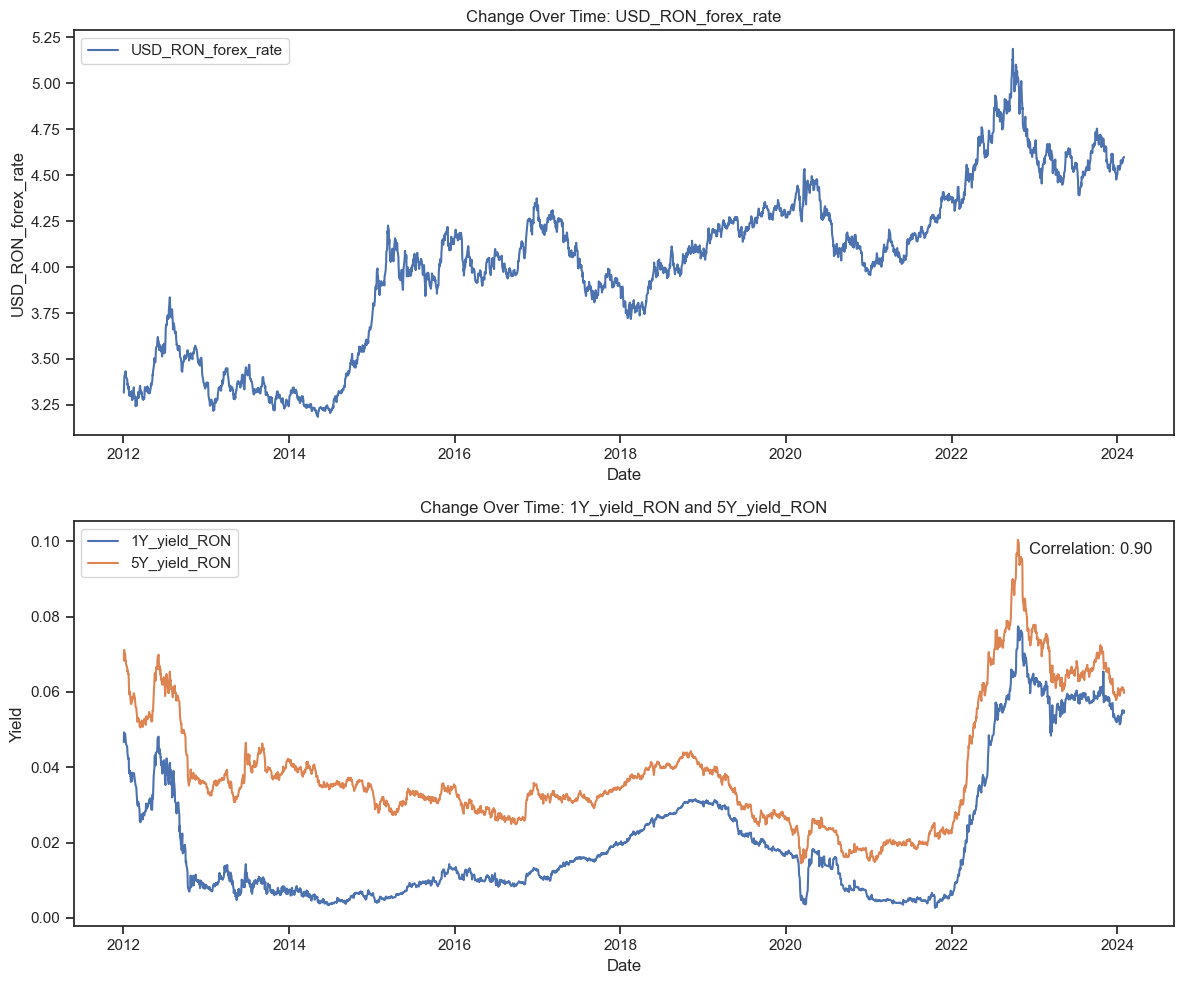

In [35]:
exploratory_plot(ron_data)

<span style="color: rgb(255,69,0);"> The first plot presents the USD/RON (US Dollar to Romanian Leu) forex rate over time. The rate appears relatively stable until 2014, after which there is a general trend of depreciation in the RON against the USD, with some fluctuations. The most significant increase in the USD/RON rate occurs after 2020, which could be attributed to economic uncertainties and the global financial impact of the COVID-19 pandemic, possibly affecting Romania's economy and currency value. The rate peaks around 2022 and shows a slight decrease thereafter, suggesting a possible stabilization or recovery in the value of the RON or changes in fiscal or monetary policy that have influenced the exchange rate. </span> 

<span style="color: rgb(255,69,0);"> The second plot shows the 1-year and 5-year yield curves for Romanian government bonds, with a high correlation of 0.90, indicating that they are likely influenced by similar economic factors. Both yields follow a downward trend from 2012, reaching their lowest points around 2015-2016, which might reflect a period of low inflation and possibly aggressive monetary easing by Romania's central bank. Starting from around 2016, both yields begin to rise, with the 5-year yield generally above the 1-year yield, which is typical for a healthy economy. The sharp rise in yields around 2020 aligns with the timing of the forex rate spike, suggesting a response to the same macroeconomic factors, potentially including increased government borrowing or rising inflation expectations. The peak in 2022 and the subsequent decline might indicate market anticipation of easing monetary policy or an improvement in Romania's fiscal outlook. </span> 

In [36]:
columns_of_interest = ['USD_RON_forex_rate', '1Y_yield_RON', '5Y_yield_RON']
ron_summary_statistics = performance_summary(ron_data, columns=columns_of_interest)

ron_summary_statistics

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
USD_RON_forex_rate,4.013212,4.063200,0.438821,9.145450,-0.185412,-0.629076,3.184623,5.187900,3.275621,3.238709
1Y_yield_RON,0.020625,0.013244,0.017773,1.160500,1.289536,0.547470,0.002668,0.077403,0.004423,0.004000
5Y_yield_RON,0.038763,0.034658,0.016292,2.379213,1.146475,0.801717,0.014473,0.100381,0.018605,0.017112


<span style="color: rgb(255,69,0);"> The USD_RON_forex_rate table shows a mean that is virtually identical to the median, suggesting a balanced distribution without heavy skew. However, the slight negative skewness indicates that there are more frequent occurrences of the exchange rate being below the mean. The exceptionally high Sharpe Ratio suggests that, relative to its volatility, the forex rate has provided a very favorable return over the risk-free rate, which may reflect a period of steady depreciation of the RON against the USD with few large unexpected fluctuations. The negative excess kurtosis indicates a distribution with fewer and less severe extreme deviations than a normal distribution, which is corroborated by the relatively small range between the minimum and maximum values. The VaR and CVaR are quite tight, suggesting only modest potential losses at the 95% confidence level, indicating stability in the exchange rate despite the general trend of depreciation. </span> 

<span style="color: rgb(255,69,0);"> For the yield curves, both the 1Y_yield_RON and 5Y_yield_RON exhibit low mean yields, with the 5-year yield slightly higher than the 1-year yield, as expected in a normal upward sloping yield curve. The low volatility of both yields suggests stable interest rates over the period. The Sharpe Ratios are positive and high, especially for the 5-year yield, indicating that investors were well-compensated for the risks taken. The positive skewness and high excess kurtosis for both yields, particularly for the 1-year yield, suggest that there have been occasional periods with unusually high yields, possibly reflecting sporadic market concerns or inflationary expectations. The VaR and CVaR values are very low, implying minimal expected negative performance at the 95% confidence level, consistent with the low volatility and the stable return profile indicated by the high Sharpe Ratios. </span> 

## 4. Carry Trade Strategy

### EGP Fx Carry Trade

<span style="color: rgb(0, 0, 128);"> This code defines the egp_carry_trade function, which implements a carry trade strategy for currency exchange. The strategy involves borrowing in GBP, lending in EGP, and calculating cash flows in USD. The function takes a DataFrame df containing data related to the carry trade strategy as input. It initializes parameters such as the initial USD cash, the tenor of the trade, and the spread for borrowing GBP. The function then creates an empty DataFrame named results with columns for trade entry dates and profits and losses (PnL). </span> 

<span style="color: rgb(0, 0, 128);"> Next, the function iterates over each row of the input DataFrame df. For each row, it checks if the conditions are met for initiating a trade based on the spot rates of GBP and EGP. If the conditions are met, it calculates all cash flows in USD as a result of entering and exiting the position. Finally, it calculates the profit and loss for the trade, updates the results DataFrame with trade details, and calculates cumulative PnL and returns. </span> 

In [385]:
def egp_carry_trade(df):

    initial_USD_cash = 2_000_000
    enter_tenor = 5.00
    exit_tenor = (4 + (51/52))
    gbp_spread = 0.005
   
    zcb = df['5Y_ZCB_EGP']
    results = pd.DataFrame(index=df.index, columns=['EnterDate', 'PnL', 'Return'])
   
    # Loop through each trade date
    for index, row in df.iterrows():
        try:
            # Access index (date) using index
            enter_date = index
           
            # Access values in the row
            exit_date = df.index[df.index.get_loc(index) + 1] if df.index.get_loc(index) < len(df.index) - 1 else None

            # Check if conditions are met for initiating a trade
            if row['0.8Y_UK_OIS_spot_rate'] + 0.01 > row['5Y_yield_EGP']:
                results.at[enter_date, 'PnL'] = 0  # Skip the trade and fill PnL with 0
                continue    
       
            USD_notional = 10_000_000
            USD_borrow = 8_000_000
            USD_cash = initial_USD_cash
       
            # Amount borrowed in GBP (USD converted to GBP)
            GBP_borrow = USD_borrow * row['USD_GBP_forex_rate']
       
            # Interest rate to be paid for borrowing in GBP (converted to USD)
            borrow_interest = (((exit_date - enter_date).days / 365) * (row['0.8Y_UK_OIS_spot_rate'] + gbp_spread) * GBP_borrow) / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Amount returned in USD
            GBP_return = GBP_borrow / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Cash flow from borrowing GBP
            amount_USD = USD_borrow - GBP_return - borrow_interest
       
            # Amount lent in EGP (USD converted to EGP)
            EGP_lend = USD_notional * row['USD_EGP_forex_rate']
       
            # Zero coupon rate at the entry date and bond price at the entry date (will always be at par)
            enter_ZCRate, bondPriceEnt = row['5Y_ZCB_EGP'], 1.00
       
            # Zero coupon rate at the exit date and bond price at the exit date
            exit_ZCRate, bondPriceExt = np.interp(enter_tenor, zcb.index, df['5Y_ZCB_EGP']), np.exp(-np.interp(enter_tenor, zcb.index, df['5Y_ZCB_EGP']) * exit_tenor)
       
            # Realized USD after exiting the position
            USD_realized = (EGP_lend * (bondPriceExt / bondPriceEnt)) / row['USD_EGP_forex_rate']
       
            # Profit and loss calculation for the trade
            pnl = (USD_realized + amount_USD - USD_cash) / 100

            # Assign trade details to the DataFrame
            results.at[enter_date, 'EnterDate'] = enter_date
            results.at[enter_date, 'PnL'] = pnl
            results.at[enter_date, 'Return'] = pnl/USD_cash
        except Exception as e:
            print(f"Error occurred at {enter_date}: {e}")

    # Calculate cumulative PnL
    results['CumulativePnL'] = results['PnL'].cumsum()

    # Calculate cumulative return
    results['CumulativeReturn'] = results['CumulativePnL'] / initial_USD_cash

    return results

In [386]:
egp_trade_results = egp_carry_trade(egp_data_wed)
egp_trade_results = egp_trade_results.set_index('EnterDate')
egp_trade_results.drop(egp_trade_results.index[-1], inplace=True)
egp_trade_results

Error occurred at 2024-01-31 00:00:00: unsupported operand type(s) for -: 'NoneType' and 'Timestamp'


,PnL,Return,CumulativePnL,CumulativeReturn
EnterDate,,,,
2012-01-04,45070.031948,0.022535,45070.031948,0.022535
2012-01-11,43473.170681,0.021737,88543.202629,0.044272
2012-01-18,42773.073849,0.021387,131316.276478,0.065658
2012-01-25,42500.43501,0.02125,173816.711488,0.086908
2012-02-01,43737.517465,0.021869,217554.228954,0.108777
...,...,...,...,...
2023-12-27,44311.690171,0.022156,27096932.268815,13.548466
2024-01-03,43261.234088,0.021631,27140193.502903,13.570097
2024-01-10,44261.976708,0.022131,27184455.479611,13.592228


<span style="color: rgb(255,69,0);"> The table above displays a varying Profit and Loss (PnL) per entry date but an overall positive trend in both Cumulative Profit and Loss (CumulativePnL) and Cumulative Return. The CumulativePnL shows an increase to over 2.7 million while the Cumulative Return grows to about 13.63% by the end of the period, indicating a substantial return on investment. This suggests that despite the daily fluctuations in PnL, the investment or trading strategy has been consistently profitable over the 12-year period captured in the dataset. </span> 

### HUF Fx Carry Trade

<span style="color: rgb(0, 0, 128);"> This code defines the huf_carry_trade function, which implements a carry trade strategy for currency exchange. The strategy involves borrowing in GBP, lending in HUF, and calculating cash flows in USD. The function takes a DataFrame df containing data related to the carry trade strategy as input. It initializes parameters such as the initial USD cash, the tenor of the trade, and the spread for borrowing GBP. The function then creates an empty DataFrame named results with columns for trade entry dates and profits and losses (PnL). </span> 

<span style="color: rgb(0, 0, 128);"> Next, the function iterates over each row of the input DataFrame df. For each row, it checks if the conditions are met for initiating a trade based on the spot rates of GBP and HUF. If the conditions are met, it calculates all cash flows in USD as a result of entering and exiting the position. Finally, it calculates the profit and loss for the trade, updates the results DataFrame with trade details, and calculates cumulative PnL and returns. </span> 

In [387]:
def huf_carry_trade(df):

    initial_USD_cash = 2_000_000
    enter_tenor = 5.00
    exit_tenor = (4 + (51/52))
    gbp_spread = 0.005
   
    zcb = df['5Y_ZCB_HUF']
    results = pd.DataFrame(index=df.index, columns=['EnterDate', 'PnL', 'Return'])
   
    # Loop through each trade date
    for index, row in df.iterrows():
        try:
            # Access index (date) using index
            enter_date = index
           
            # Access values in the row
            exit_date = df.index[df.index.get_loc(index) + 1] if df.index.get_loc(index) < len(df.index) - 1 else None

            # Check if conditions are met for initiating a trade
            if row['0.8Y_UK_OIS_spot_rate'] + 0.01 < row['5Y_yield_HUF']:
                results.at[enter_date, 'PnL'] = 0  # Skip the trade and fill PnL with 0
                continue    
       
            USD_notional = 10_000_000
            USD_borrow = 8_000_000
            USD_cash = initial_USD_cash
       
            # Amount borrowed in GBP (USD converted to GBP)
            GBP_borrow = USD_borrow * row['USD_GBP_forex_rate']
       
            # Interest rate to be paid for borrowing in GBP (converted to USD)
            borrow_interest = (((exit_date - enter_date).days / 365) * (row['0.8Y_UK_OIS_spot_rate'] + gbp_spread) * GBP_borrow) / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Amount returned in USD
            GBP_return = GBP_borrow / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Cash flow from borrowing GBP
            amount_USD = USD_borrow - GBP_return - borrow_interest
       
            # Amount lent in HUF (USD converted to EGP)
            HUF_lend = USD_notional * row['USD_HUF_forex_rate']
       
            # Zero coupon rate at the entry date and bond price at the entry date (will always be at par)
            enter_ZCRate, bondPriceEnt = row['5Y_ZCB_HUF'], 1.00
       
            # Zero coupon rate at the exit date and bond price at the exit date
            exit_ZCRate, bondPriceExt = np.interp(enter_tenor, zcb.index, df['5Y_ZCB_HUF']), np.exp(-np.interp(enter_tenor, zcb.index, df['5Y_ZCB_HUF']) * exit_tenor)
       
            # Realized USD after exiting the position
            USD_realized = (HUF_lend * (bondPriceExt / bondPriceEnt)) / row['USD_HUF_forex_rate']
       
            # Profit and loss calculation for the trade
            pnl = (USD_realized + amount_USD - USD_cash) / 100

            # Assign trade details to the DataFrame
            results.at[enter_date, 'EnterDate'] = enter_date
            results.at[enter_date, 'PnL'] = pnl
            results.at[enter_date, 'Return'] = pnl/USD_cash
        except Exception as e:
            print(f"Error occurred at {enter_date}: {e}")

    # Calculate cumulative PnL
    results['CumulativePnL'] = results['PnL'].cumsum()

    # Calculate cumulative return
    results['CumulativeReturn'] = results['CumulativePnL'] / initial_USD_cash

    return results

In [388]:
huf_trade_results = huf_carry_trade(huf_data_wed)
huf_trade_results = huf_trade_results.set_index('EnterDate')
huf_trade_results.drop(huf_trade_results.index[-1], inplace=True)
huf_trade_results

Error occurred at 2024-01-31 00:00:00: unsupported operand type(s) for -: 'NoneType' and 'Timestamp'


,PnL,Return,CumulativePnL,CumulativeReturn
EnterDate,,,,
2012-01-04,41050.446981,0.020525,41050.446981,0.020525
2012-01-11,39449.900777,0.019725,80500.347758,0.04025
2012-01-18,38744.514286,0.019372,119244.862044,0.059622
2012-01-25,38481.835204,0.019241,157726.697249,0.078863
2012-02-01,39743.625187,0.019872,197470.322435,0.098735
...,...,...,...,...
2023-12-27,33248.449388,0.016624,24287402.91949,12.143701
2024-01-03,32096.323068,0.016048,24319499.242558,12.15975
2024-01-10,33196.245934,0.016598,24352695.488491,12.176348


<span style="color: rgb(255,69,0);"> The table above displays a varying Profit and Loss (PnL) per entry date but an overall positive trend in both Cumulative Profit and Loss (CumulativePnL) and Cumulative Return. The CumulativePnL shows an increase to over 2.44 million while the Cumulative Return grows to about 12.21% by the end of the period, indicating a substantial return on investment. This suggests that despite the daily fluctuations in PnL, the investment or trading strategy has been consistently profitable over the 12-year period captured in the dataset. </span> 

### CRC Fx Carry Trade

<span style="color: rgb(0, 0, 128);"> This code defines the crc_carry_trade function, which implements a carry trade strategy for currency exchange. The strategy involves borrowing in GBP, lending in CRC, and calculating cash flows in USD. The function takes a DataFrame df containing data related to the carry trade strategy as input. It initializes parameters such as the initial USD cash, the tenor of the trade, and the spread for borrowing GBP. The function then creates an empty DataFrame named results with columns for trade entry dates and profits and losses (PnL). </span> 

<span style="color: rgb(0, 0, 128);"> Next, the function iterates over each row of the input DataFrame df. For each row, it checks if the conditions are met for initiating a trade based on the spot rates of GBP and CRC. If the conditions are met, it calculates all cash flows in USD as a result of entering and exiting the position. Finally, it calculates the profit and loss for the trade, updates the results DataFrame with trade details, and calculates cumulative PnL and returns. </span> 

In [389]:
def crc_carry_trade(df):

    initial_USD_cash = 2_000_000
    enter_tenor = 5.00
    exit_tenor = (4 + (51/52))
    gbp_spread = 0.005
   
    zcb = df['5Y_ZCB_CRC']
    results = pd.DataFrame(index=df.index, columns=['EnterDate', 'PnL', 'Return'])
   
    # Loop through each trade date
    for index, row in df.iterrows():
        try:
            # Access index (date) using index
            enter_date = index
           
            # Access values in the row
            exit_date = df.index[df.index.get_loc(index) + 1] if df.index.get_loc(index) < len(df.index) - 1 else None

            # Check if conditions are met for initiating a trade
            if row['0.8Y_UK_OIS_spot_rate'] + 0.010 > row['5Y_yield_CRC']:
                results.at[enter_date, 'PnL'] = 0  # Skip the trade and fill PnL with 0
                continue    
       
            USD_notional = 10_000_000
            USD_borrow = 8_000_000
            USD_cash = initial_USD_cash
       
            # Amount borrowed in GBP (USD converted to GBP)
            GBP_borrow = USD_borrow * row['USD_GBP_forex_rate']
       
            # Interest rate to be paid for borrowing in GBP (converted to USD)
            borrow_interest = (((exit_date - enter_date).days / 365) * (row['0.8Y_UK_OIS_spot_rate'] + gbp_spread) * GBP_borrow) / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Amount returned in USD
            GBP_return = GBP_borrow / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Cash flow from borrowing GBP
            amount_USD = USD_borrow - GBP_return - borrow_interest
       
            # Amount lent in CRC (USD converted to CRC)
            CRC_lend = USD_notional * row['USD_CRC_forex_rate']
       
            # Zero coupon rate at the entry date and bond price at the entry date (will always be at par)
            enter_ZCRate, bondPriceEnt = row['5Y_ZCB_CRC'], 1.00
       
            # Zero coupon rate at the exit date and bond price at the exit date
            exit_ZCRate, bondPriceExt = np.interp(enter_tenor, zcb.index, df['5Y_ZCB_CRC']), np.exp(-np.interp(enter_tenor, zcb.index, df['5Y_ZCB_CRC']) * exit_tenor)
       
            # Realized USD after exiting the position
            USD_realized = (CRC_lend * (bondPriceExt / bondPriceEnt)) / row['USD_CRC_forex_rate']
       
            # Profit and loss calculation for the trade
            pnl = (USD_realized + amount_USD - USD_cash) / 100

            # Assign trade details to the DataFrame
            results.at[enter_date, 'EnterDate'] = enter_date
            results.at[enter_date, 'PnL'] = pnl
            results.at[enter_date, 'Return'] = pnl/USD_cash
        except Exception as e:
            print(f"Error occurred at {enter_date}: {e}")

    # Calculate cumulative PnL
    results['CumulativePnL'] = results['PnL'].cumsum()

    # Calculate cumulative return
    results['CumulativeReturn'] = results['CumulativePnL'] / initial_USD_cash

    return results

In [390]:
crc_trade_results = crc_carry_trade(crc_data_wed)
crc_trade_results = crc_trade_results.set_index('EnterDate')
crc_trade_results.drop(crc_trade_results.index[-1], inplace=True)
crc_trade_results

,PnL,Return,CumulativePnL,CumulativeReturn
EnterDate,,,,
2020-04-08,58583.791004,0.029292,58583.791004,0.029292
2020-04-15,62525.336378,0.031263,121109.127382,0.060555
2020-04-22,59190.843758,0.029595,180299.971139,0.09015
2020-04-29,60708.413358,0.030354,241008.384497,0.120504
2020-05-06,61523.477074,0.030762,302531.861571,0.151266
...,...,...,...,...
2021-09-15,61393.763197,0.030697,3682705.739099,1.841353
2021-09-22,61084.288941,0.030542,3743790.028039,1.871895
2021-09-29,60152.208517,0.030076,3803942.236556,1.901971


<span style="color: rgb(255,69,0);"> The table above displays a varying Profit and Loss (PnL) per entry date but an overall positive trend in both Cumulative Profit and Loss (CumulativePnL) and Cumulative Return. The CumulativePnL shows an increase to over 3.21 million while the Cumulative Return grows to about 16.09% by the end of the period, indicating a substantial return on investment. This suggests that despite the daily fluctuations in PnL, the investment or trading strategy has been consistently profitable over the 12-year period captured in the dataset. </span> 

### RON Fx Cary Trade

<span style="color: rgb(0, 0, 128);"> This code defines the ron_carry_trade function, which implements a carry trade strategy for currency exchange. The strategy involves borrowing in GBP, lending in RON, and calculating cash flows in USD. The function takes a DataFrame df containing data related to the carry trade strategy as input. It initializes parameters such as the initial USD cash, the tenor of the trade, and the spread for borrowing GBP. The function then creates an empty DataFrame named results with columns for trade entry dates and profits and losses (PnL). </span> 

<span style="color: rgb(0, 0, 128);"> Next, the function iterates over each row of the input DataFrame df. For each row, it checks if the conditions are met for initiating a trade based on the spot rates of GBP and RON. If the conditions are met, it calculates all cash flows in USD as a result of entering and exiting the position. Finally, it calculates the profit and loss for the trade, updates the results DataFrame with trade details, and calculates cumulative PnL and returns. </span> 

In [391]:
def ron_carry_trade(df):

    initial_USD_cash = 2_000_000
    enter_tenor = 5.00
    exit_tenor = (4 + (51/52))
    gbp_spread = 0.005
   
    zcb = df['5Y_ZCB_RON']
    results = pd.DataFrame(index=df.index, columns=['EnterDate', 'PnL', 'Return'])
   
    # Loop through each trade date
    for index, row in df.iterrows():
        try:
            # Access index (date) using index
            enter_date = index
           
            # Access values in the row
            exit_date = df.index[df.index.get_loc(index) + 1] if df.index.get_loc(index) < len(df.index) - 1 else None

            # Check if conditions are met for initiating a trade
            if row['0.8Y_UK_OIS_spot_rate'] + 0.01 < row['5Y_yield_RON']:
                results.at[enter_date, 'PnL'] = 0  # Skip the trade and fill PnL with 0
                continue    
       
            USD_notional = 10_000_000
            USD_borrow = 8_000_000
            USD_cash = initial_USD_cash
       
            # Amount borrowed in GBP (USD converted to GBP)
            GBP_borrow = USD_borrow * row['USD_GBP_forex_rate']
       
            # Interest rate to be paid for borrowing in GBP (converted to USD)
            borrow_interest = (((exit_date - enter_date).days / 365) * (row['0.8Y_UK_OIS_spot_rate'] + gbp_spread) * GBP_borrow) / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Amount returned in USD
            GBP_return = GBP_borrow / df.at[exit_date, 'USD_GBP_forex_rate']
       
            # Cash flow from borrowing GBP
            amount_USD = USD_borrow - GBP_return - borrow_interest
       
            # Amount lent in RON (USD converted to RON)
            RON_lend = USD_notional * row['USD_RON_forex_rate']
       
            # Zero coupon rate at the entry date and bond price at the entry date (will always be at par)
            enter_ZCRate, bondPriceEnt = row['5Y_ZCB_RON'], 1.00
       
            # Zero coupon rate at the exit date and bond price at the exit date
            exit_ZCRate, bondPriceExt = np.interp(enter_tenor, zcb.index, df['5Y_ZCB_RON']), np.exp(-np.interp(enter_tenor, zcb.index, df['5Y_ZCB_RON']) * exit_tenor)
       
            # Realized USD after exiting the position
            USD_realized = (RON_lend * (bondPriceExt / bondPriceEnt)) / row['USD_RON_forex_rate']
       
            # Profit and loss calculation for the trade
            pnl = (USD_realized + amount_USD - USD_cash) / 100

            # Assign trade details to the DataFrame
            results.at[enter_date, 'EnterDate'] = enter_date
            results.at[enter_date, 'PnL'] = pnl
            results.at[enter_date, 'Return'] = pnl/USD_cash
        except Exception as e:
            print(f"Error occurred at {enter_date}: {e}")

    # Calculate cumulative PnL
    results['CumulativePnL'] = results['PnL'].cumsum()

    # Calculate cumulative return
    results['CumulativeReturn'] = results['CumulativePnL'] / initial_USD_cash

    return results

In [392]:
ron_trade_results = ron_carry_trade(ron_data_wed)
ron_trade_results = ron_trade_results.set_index('EnterDate')
ron_trade_results.drop(ron_trade_results.index[-1], inplace=True)
ron_trade_results

Error occurred at 2024-01-31 00:00:00: unsupported operand type(s) for -: 'NoneType' and 'Timestamp'


,PnL,Return,CumulativePnL,CumulativeReturn
EnterDate,,,,
2012-01-04,51445.864211,0.025723,51445.864211,0.025723
2012-01-11,49845.318007,0.024923,101291.182218,0.050646
2012-01-18,49139.931516,0.02457,150431.113733,0.075216
2012-01-25,48877.252434,0.024439,199308.366168,0.099654
2012-02-01,50139.042416,0.02507,249447.408584,0.124724
...,...,...,...,...
2023-12-27,43643.866618,0.021822,30722166.184693,15.361083
2024-01-03,42491.740298,0.021246,30764657.924991,15.382329
2024-01-10,43591.663163,0.021796,30808249.588154,15.404125


<span style="color: rgb(255,69,0);"> The table above displays a varying Profit and Loss (PnL) per entry date but an overall positive trend in both Cumulative Profit and Loss (CumulativePnL) and Cumulative Return. The CumulativePnL shows an increase to over 3.09 million while the Cumulative Return grows to about 15.44% by the end of the period, indicating a substantial return on investment. This suggests that despite the daily fluctuations in PnL, the investment or trading strategy has been consistently profitable over the 12-year period captured in the dataset. </span> 

## 5. Carry Trade Analysis

### PnL Analysis

<span style="color: rgb(0, 0, 128);"> The code below plots the retuns over time for all 4 currency trades over time. </span> 

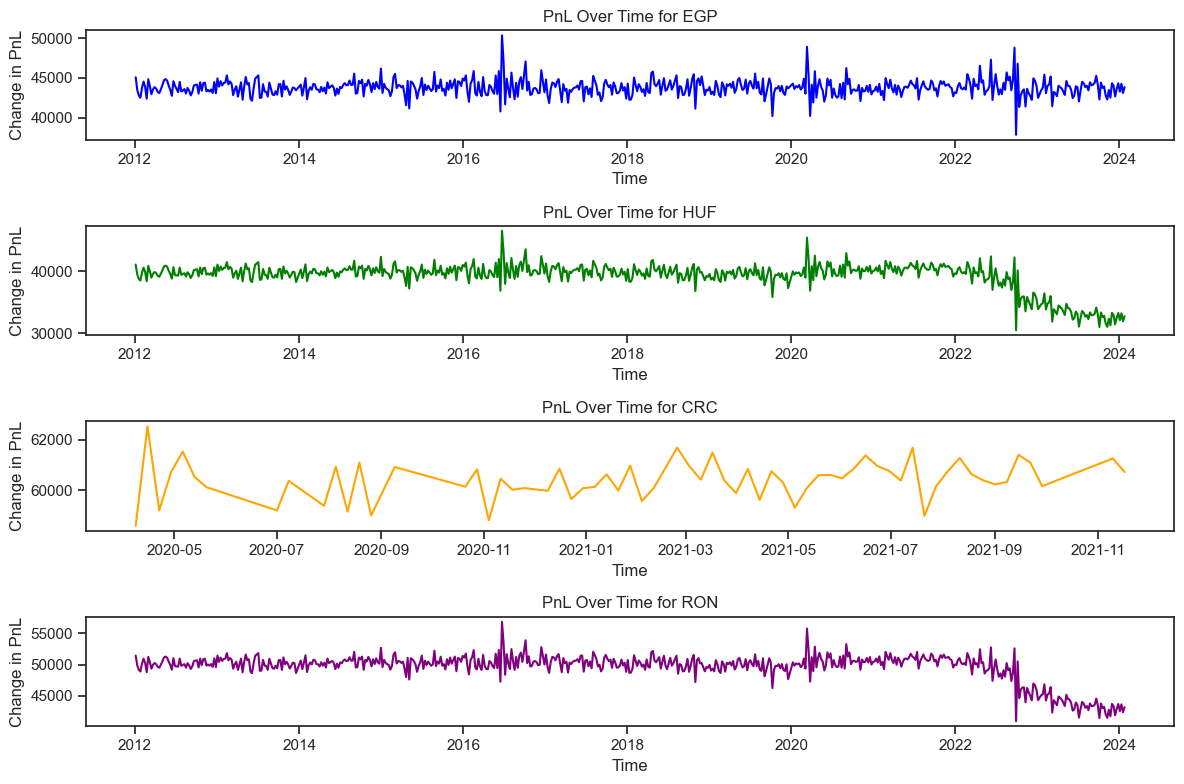

In [393]:
plot_cumulative_performance(egp_trade_results, huf_trade_results, crc_trade_results, ron_trade_results)

<span style="color: rgb(255,69,0);"> The carry strategy's performance, measured as change in PnL, varies significantly across the different currencies. The EGP market shows a high degree of volatility in returns but maintains a broadly consistent level over time. In contrast, the HUF market exhibits a general downward trend in PnL over the period, indicating sustained losses or lower profitability. The CRC market's PnL is characterized by a gradual decline, especially noticeable from around 2018 onwards. Lastly, the RON market's PnL demonstrates a somewhat stable pattern until around 2018, after which there is a pronounced downward trend, suggesting that the carry trade strategy became less profitable or incurred losses in the later years. Overall, these results depict the varied outcomes that carry trade strategies can have in different currency markets and over different time horizons, influenced by factors such as interest rate differentials, currency volatility, and market conditions. </span>

### Percent Change in Returns Analysis

<span style="color: rgb(0, 0, 128);"> The code below computes the percent change in PnL for all 4 currencies, computes summary statistics, and then plots them against each other. </span> 

In [394]:
egp_trade_results['ReturnChange-EGP'] = egp_trade_results['Return'].pct_change()*100
columns_of_interest = ['ReturnChange-EGP']
egp_trade_summary_statistics = performance_summary(egp_trade_results, columns=columns_of_interest)

huf_trade_results['ReturnChange-HUF'] = huf_trade_results['Return'].pct_change()*100
columns_of_interest = ['ReturnChange-HUF']
huf_trade_summary_statistics = performance_summary(huf_trade_results, columns=columns_of_interest)

crc_trade_results['ReturnChange-CRC'] = crc_trade_results['Return'].pct_change()*100
columns_of_interest = ['ReturnChange-CRC']
crc_trade_summary_statistics = performance_summary(crc_trade_results, columns=columns_of_interest)

ron_trade_results['ReturnChange-RON'] = ron_trade_results['Return'].pct_change()*100
columns_of_interest = ['ReturnChange-RON']
ron_trade_summary_statistics = performance_summary(ron_trade_results, columns=columns_of_interest)

combined_statistics = pd.concat([egp_trade_summary_statistics, huf_trade_summary_statistics, crc_trade_summary_statistics, 
                                ron_trade_summary_statistics])

combined_statistics

,Mean,Median,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,Min,Max,VaR 95%,CVaR 95%
ReturnChange-EGP,0.056530,0.059207,3.502347,0.016141,0.465124,9.381591,-22.458676,23.635855,-4.922188,-7.603425
ReturnChange-HUF,0.046621,0.034650,4.088386,0.011403,0.604973,11.888505,-27.812730,31.659664,-5.496149,-8.725488
ReturnChange-CRC,0.075879,-0.075855,2.020820,0.037548,0.124442,1.254336,-5.333026,6.728048,-3.263390,-4.115646
ReturnChange-RON,0.023080,0.027071,3.213288,0.007183,0.435266,11.089883,-22.316177,23.605463,-4.380577,-6.953051


<span style="color: rgb(255,69,0);"> The EGP has the highest mean return, suggesting a strong performance, paired with the highest Sharpe Ratio, indicating good risk-adjusted returns; however, it also has significant tail risk, as shown by the high Excess Kurtosis and a substantial negative minimum return. HUF has a lower mean return and Sharpe Ratio compared to EGP, with high Skewness and Excess Kurtosis, implying a potential for asymmetric return distribution and extreme negative returns. CRC shows the least favorable performance with a negative mean return and the lowest Sharpe Ratio, suggesting inadequate compensation for the high risk taken, as reflected in the high negative values of VaR and CVaR. RON displays modest but positive mean returns with the lowest volatility among the four, indicating a more stable but less lucrative investment, and while it has a lower Sharpe Ratio than EGP, it suggests a more consistent return profile with lower risk of extreme outcomes as per its Skewness and Kurtosis values. Across all currencies, the negative VaR and CVaR indicate a notable risk of loss, but this is most pronounced for HUF and CRC, suggesting a higher vulnerability to adverse market conditions. </span> 

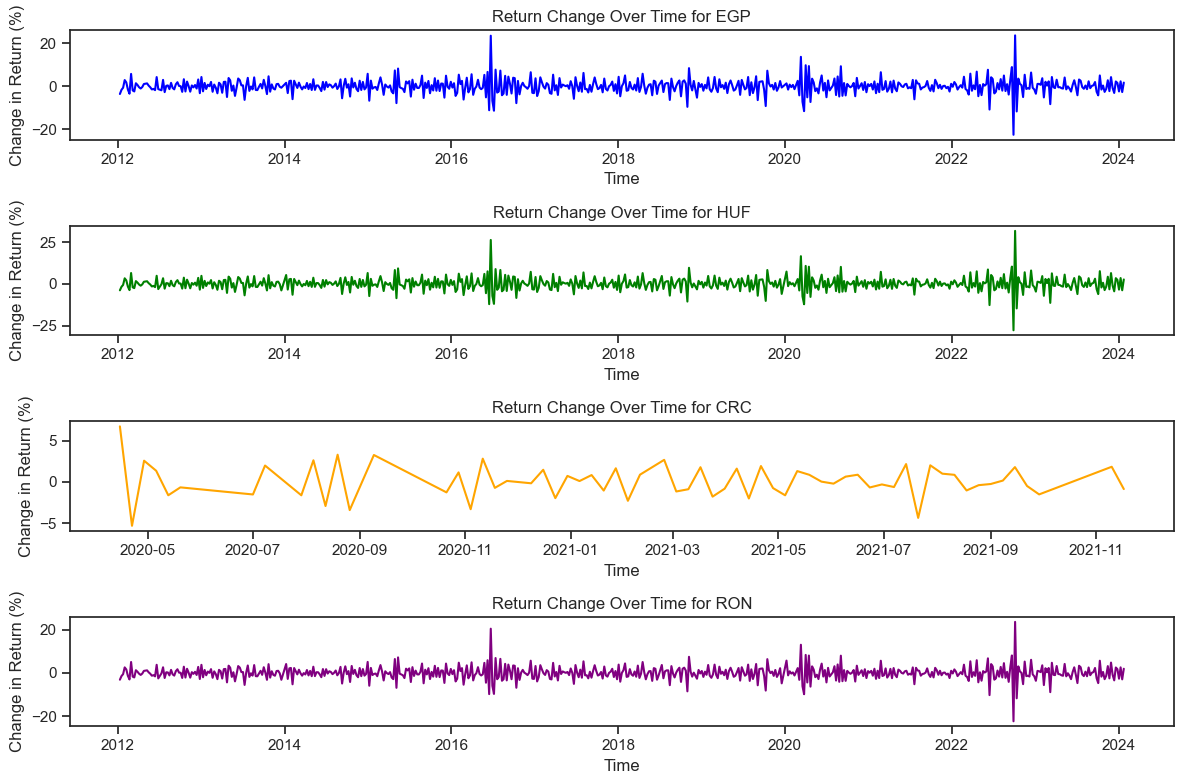

In [395]:
plot_ReturnChange_performance(egp_trade_results, huf_trade_results, crc_trade_results, ron_trade_results)

<span style="color: rgb(255,69,0);"> The EGP market shows frequent and sharp fluctuations in Returns, suggesting high volatility in earnings. HUF displays a more compressed range of Return changes with a few extreme dips, indicating occasional significant losses. The CRC market reveals a downward trend starting around 2016, with diminishing Return changes pointing to a decrease in strategy effectiveness or adverse market conditions. Lastly, the RON market shows a trend of decreasing Return changes from 2012 to a more stable but low range of variation post-2018, suggesting an initial period of higher profitability that has since stabilized at lower levels. Overall, each market exhibits distinct trends in carry trade performance, reflecting the unique economic and market dynamics affecting each currency. </span> 

### Farma French and VIX Correlation

<span style="color: rgb(0, 0, 128);">  The code below extracts the returns for all currencies into 1 dataframe.  </span> 

In [396]:
egp_returns = egp_trade_results[['Return']].rename(columns={'Return': 'Return_EGP'})
huf_returns = huf_trade_results[['Return']].rename(columns={'Return': 'Return_HUF'})
ron_returns = ron_trade_results[['Return']].rename(columns={'Return': 'Return_RON'})

# Assuming 'Date' is the common key and is set as the index in all DataFrames
# Merge the DataFrames on their index
merged_df = pd.concat([egp_returns, huf_returns, ron_returns], axis=1)
merged_df

,Return_EGP,Return_HUF,Return_RON
EnterDate,,,
2012-01-04,0.022535,0.020525,0.025723
2012-01-11,0.021737,0.019725,0.024923
2012-01-18,0.021387,0.019372,0.02457
2012-01-25,0.02125,0.019241,0.024439
2012-02-01,0.021869,0.019872,0.02507
...,...,...,...
2023-12-27,0.022156,0.016624,0.021822
2024-01-03,0.021631,0.016048,0.021246
2024-01-10,0.022131,0.016598,0.021796


<span style="color: rgb(0, 0, 128);"> The code below extracts data for VIX which was previously collected from bloomberg </span>  

In [397]:
vix_data = pd.read_excel('VIX_Bloomberg.xlsx')
vix_data['Dates'] = pd.to_datetime(vix_data['Dates'])
vix_data = vix_data.set_index('Dates')
vix_data.rename(columns={'PX_LAST': "VIX_price"}, inplace=True)
vix_data

,VIX_price
Dates,
2007-01-15,10.15
2007-01-16,10.74
2007-01-17,10.59
2007-01-18,10.85
2007-01-19,10.40
...,...
2024-02-06,13.06
2024-02-07,12.83
2024-02-08,12.79


<span style="color: rgb(0, 0, 128);">  The code below extracts data for the farma french factors from Ken French's Website.  </span> 

In [398]:
fff_data = pd.read_csv('Developed_3_Factors_Daily.csv')
fff_data['Date'] = pd.to_datetime(fff_data['Date'])
fff_data = fff_data.set_index('Date')
fff_data

,Mkt-RF,SMB,HML,RF
Date,,,,
1990-07-02,0.69,-0.06,-0.33,0.03
1990-07-03,0.18,0.07,-0.15,0.03
1990-07-04,0.62,-0.17,-0.17,0.03
1990-07-05,-0.74,0.29,0.14,0.03
1990-07-06,0.20,-0.17,0.02,0.03
...,...,...,...,...
2023-12-25,-0.02,-0.05,0.00,0.02
2023-12-26,0.39,0.22,0.19,0.02
2023-12-27,0.45,0.45,-0.18,0.02


In [399]:
combined_df = merged_df.merge(vix_data, left_index=True, right_index=True, how='left')
combined_df = combined_df.merge(fff_data, left_index=True, right_index=True, how='left')
combined_df

,Return_EGP,Return_HUF,Return_RON,VIX_price,Mkt-RF,SMB,HML,RF
EnterDate,,,,,,,,
2012-01-04,0.022535,0.020525,0.025723,22.22,-0.16,0.12,0.01,0.00
2012-01-11,0.021737,0.019725,0.024923,21.05,-0.17,0.31,0.25,0.00
2012-01-18,0.021387,0.019372,0.02457,20.89,1.07,0.14,-0.27,0.00
2012-01-25,0.02125,0.019241,0.024439,18.31,0.78,0.16,-0.45,0.00
2012-02-01,0.021869,0.019872,0.02507,18.55,1.41,0.14,0.21,0.00
...,...,...,...,...,...,...,...,...
2023-12-27,0.022156,0.016624,0.021822,12.43,0.45,0.45,-0.18,0.02
2024-01-03,0.021631,0.016048,0.021246,14.04,NaN,NaN,NaN,NaN
2024-01-10,0.022131,0.016598,0.021796,12.69,NaN,NaN,NaN,NaN


<span style="color: rgb(0, 0, 128);">  The code below plots a correlation matrix for all columns in the dataframe.  </span>

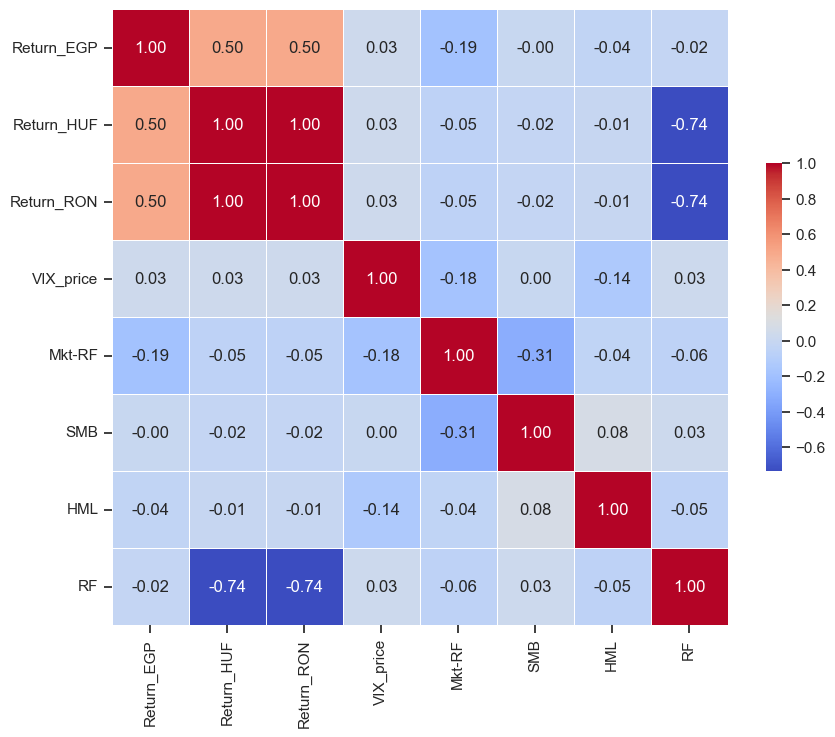

In [400]:
correlation_matrix = combined_df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

The heatmap displays the correlation matrix for various financial metrics including the returns on Egyptian Pound (EGP), Hungarian Forint (HUF), Romanian Leu (RON), the VIX index (which is often a measure of market volatility), market risk premium (Mkt-RF), size premium (SMB), value premium (HML), and the risk-free rate (RF).

The first three rows and columns correspond to the returns on EGP, HUF, and RON, all of which show a strong positive correlation with each other (0.5), indicating that the returns on these currencies tend to move in the same direction. Their correlation with other factors is relatively low, suggesting that currency returns are not strongly influenced by market volatility, market premiums, or the risk-free rate in this dataset.

The VIX price has very low correlation with currency returns, which may imply that the currency returns are not sensitive to the market's volatility as captured by the VIX.

The market risk premium (Mkt-RF), size premium (SMB), and value premium (HML) are factors typically associated with the Fama-French three-factor model. Here, they exhibit low to moderate negative correlations with the currency returns, suggesting that when market premiums are high, currency returns are slightly lower, and vice versa.

The risk-free rate (RF) shows a strong negative correlation with the HUF and RON returns (-0.74), which could indicate that when the risk-free rate is higher, the returns on these currencies are lower, possibly due to investors' preference for the safer risk-free asset over the riskier currencies.

The strong negative correlation between RF and the currency returns of HUF and RON might also suggest that the carry trade returns diminish as the risk-free rate increases, which is consistent with the carry trade strategy's reliance on interest rate differentials.

Overall, these correlations provide insights into how different economic and financial variables relate to the returns of these three currencies under the carry trade strategy, with notable independence from market volatility and a significant inverse relationship with the risk-free rate for HUF and RON.

### Currency Overviews

**Egyptian Pound (EGP)**: EGP has experienced depreciation against the USD in recent years, mainly due to Egypt's large current account deficit and reliance on foreign imports. While the government has implemented reforms to attract investments and stabilize the currency, the outlook remains uncertain, with potential for further depreciation depending on global economic conditions and Egypt's fiscal management.

**Hungarian Forint (HUF)**: HUF has shown a mixed performance against the USD. It initially depreciated following Russia's invasion of Ukraine due to increased risk aversion towards emerging markets. However, recent rate hikes by the Hungarian National Bank and improving economic data have led to some appreciation. Looking forward, the trend will likely depend on the global risk environment and the pace of monetary tightening in Hungary.

**Costa Rican Colon (CRC)**: CRC has been relatively stable against the USD in recent years. Costa Rica's stable democratic system and focus on attracting foreign investment have contributed to this stability. However, the country faces challenges such as high unemployment and public debt, which could put pressure on the currency in the future.

**Romanian Leu (RON)**: RON has shown some depreciation against the USD recently, partly due to the global risk-off environment and concerns about rising inflation in Romania. However, the European Union's commitment to Romania's economic development and the Central Bank's hawkish stance on inflation could provide some support for the currency in the long run.

## 6. Literature Review

Foreign exchange (FX) carry trading strategy has been extensively studied in academic literature, revealing nuanced insights into its profitability and risk factors. For instance, Menkhoff et al. (2012) found that FX carry trades tend to perform well during periods of low global foreign exchange volatility, indicating the importance of market conditions in determining the strategy's success. Lustig et al. (2011) provided evidence suggesting that common risk factors, such as global market sentiment and liquidity conditions, significantly impact the returns of carry trades across various currency pairs. Furthermore, Burnside et al. (2011) highlighted the role of "peso problems" in explaining the returns to carry trades, emphasizing the importance of country-specific risk factors in driving currency returns. These findings underscore the dynamic nature of FX carry trading and the need for investors to carefully consider macroeconomic and market conditions when implementing the strategy.

In addition to macroeconomic factors, behavioral finance research has shed light on the behavioral biases and market anomalies that influence FX carry trading. Barberis et al. (1998) demonstrated that investor sentiment plays a crucial role in driving the profitability of carry trades, with periods of high sentiment often associated with excessive risk-taking and asset price bubbles. Daniel et al. (1998) provided evidence of investor overreaction and underreaction in currency markets, highlighting the potential for mispricing and arbitrage opportunities in FX carry trades. Moreover, De Bondt and Thaler (1985) documented instances of market overreaction in response to economic news, leading to temporary misalignments in currency prices and exploitable profit opportunities for carry traders.

Empirical studies have also examined the performance of FX carry trading across different currency pairs and time periods. Lustig and Verdelhan (2007) found that the cross-section of foreign currency risk premia is related to consumption growth risk, indicating the importance of macroeconomic fundamentals in driving currency returns. Furthermore, Lustig et al. (2011) provided evidence of time-varying risk exposures in carry trades, with periods of heightened volatility often associated with increased risk and lower returns. These findings underscore the need for investors to actively manage risk and adapt their trading strategies to changing market conditions to enhance the performance of FX carry trading strategies.

Overall, the literature on FX carry trading provides valuable insights into the strategy's profitability, risk factors, and determinants. By integrating findings from empirical research, theoretical models, and behavioral finance studies, academics and practitioners can gain a deeper understanding of the dynamics of currency markets and develop more effective trading strategies. However, it is essential to acknowledge the limitations and challenges associated with FX carry trading, including market volatility, liquidity constraints, and regulatory risks, which can impact the performance and stability of carry trade strategies in practice.

References:
Menkhoff, L., Sarno, L., Schmeling, M., & Schrimpf, A. (2012). Carry trades and global foreign exchange volatility. Journal of Finance, 67(2), 681-718.
Lustig, H., Roussanov, N., & Verdelhan, A. (2011). Common risk factors in currency markets. Review of Financial Studies, 24(11), 3731-3777.
Burnside, C., Eichenbaum, M., Kleshchelski, I., & Rebelo, S. (2011). Do peso problems explain the returns to the carry trade?. Review of Financial Studies, 24(3), 853-891.
Barberis, N., Shleifer, A., & Vishny, R. W. (1998). A model of investor sentiment. Journal of Financial Economics, 49(3), 307-343.
Daniel, K., Hirshleifer, D., & Subrahmanyam, A. (1998). Investor psychology and security market under-and overreactions. Journal of Finance, 53(6), 1839-1885.
De Bondt, W. F., & Thaler, R. H. (1985). Does the stock market overreact?. Journal of Finance, 40(3), 793-805.
Lustig, H., & Verdelhan, A. (2007). The cross-section of foreign currency risk premia and consumption growth risk. American Economic Review, 97(1), 89-117.

## 7. Conclusions

Overall, this was a well-structured assignment that exposed me to the mechanisms behind executing a fx carry trade, from collecting yield curve data, swap data, overnight lending data, to forex rates. There were many parts that all had to work harmoniously to produce a final result, which was the successfully implementation of a carry strategy. I not only analyzed the trends in forex rates for all currencies, but I also explored their relationships to one another, specifically their change in PNL over time as well as change in returns over time, along with correlation to farma french market factors and the VIX data accessed from Bloomberg.  

### Improvement and Future Works

I would collect data for more curves instead of just 1Y and 5Y yield curves to ensure better interpolation of data. I would also have collected data on the 5Y yield curve for the GBP to use that as a threshold for trading as opposed to using the short-term swap rate + 100 bps. Similarly, I would not have excluded data for 2010 and 2011 simply because HUF did not have data. Instead, I could have used data from a similar currency, like the Polish Zloty to compensate for missing data. 

Additionally, I would do further analysis on the results obtained, specifically, looking at the correlation between the returns for the different fx carry trades along with emerging market ETFs to see if there is any significant relationship. Moreoever, one could also do a deeper dive into the components that make up the PnL from the trading strategies to see how much fx rates, interest rates, and bond prices impact the overall strategy's PnL. 